# Лабораторная работа 2. Стохастический градиентный спуск

In [1]:
from utils.config import *
from tasks import *

## Задание 1.
Реализовать стохастический градиентный спуск для решения линейной регрессии. Исследовать сходимость с разным размером батча (1 - SGD, 2...n-1 - Minibatch GD, n - GD из предыдущей работы).

In [2]:
# grad - vector gradient
# mover - returns the next point and the new lr
# x0 - initial point (np.array)
# lr - learning rate
# stop_cond - predicate indicating whether to break

def grad_descent(grad, mover, x0, lr, stop_cond):
    points = np.array([x0])
    max_epochs = 1000
    epoch = 1
    x = x0
    prev_x = None

    while (prev_x is None or not stop_cond(prev_x, x, epoch=epoch)) and epoch <= max_epochs:
        prev_x = x
        x, lr = mover(x, lr, grad, epoch=epoch, max_epochs=max_epochs)
        points = np.append(points, [x], axis=0)
        epoch += 1
    return points


def basic_mover(x, lr, grad, clip_val=DEFAULT_CLIP_VAL, **kwargs):
    return x - lr * np.clip(np.array(grad(*x)), -clip_val, clip_val), lr


def basic_exp_mover_factory(initial_lr, k=1, clip_val=DEFAULT_CLIP_VAL):
    return lambda x, lr, grad, epoch, max_epochs: (
        x - lr * np.clip(np.array(grad(*x)), -clip_val, clip_val),
        np.exp(np.log(initial_lr) - k * epoch / max_epochs))


def basic_stop_cond_factory(eps=1e-5):
    return lambda new_x, prev_x, **kwargs: sum(np.sqrt(np.abs(new_x - prev_x))) < eps


def basic_desired_cond_factory(desired=0, eps=1e-5):
    return lambda new_x, prev_x, **kwargs: abs(new_x - desired) < eps


def basic_gd(grad, x0, lr, mover=basic_mover, eps=1e-5, stop_cond=None):
    return grad_descent(grad, mover, x0.copy(), lr, basic_stop_cond_factory(eps) if stop_cond is None else stop_cond)

Для начала возьмем какую-нибудь несложную функцию и опробуем на ней реализованный выше градиентный спуск.

Пусть $f(x,y) = 0.01x^2 + 0.05y^2$

Тогда ее градиент $grad_f = [0.02x,\;0.1y]$

Параметры метода: $x_0 = (10,10),\;lr = 14$

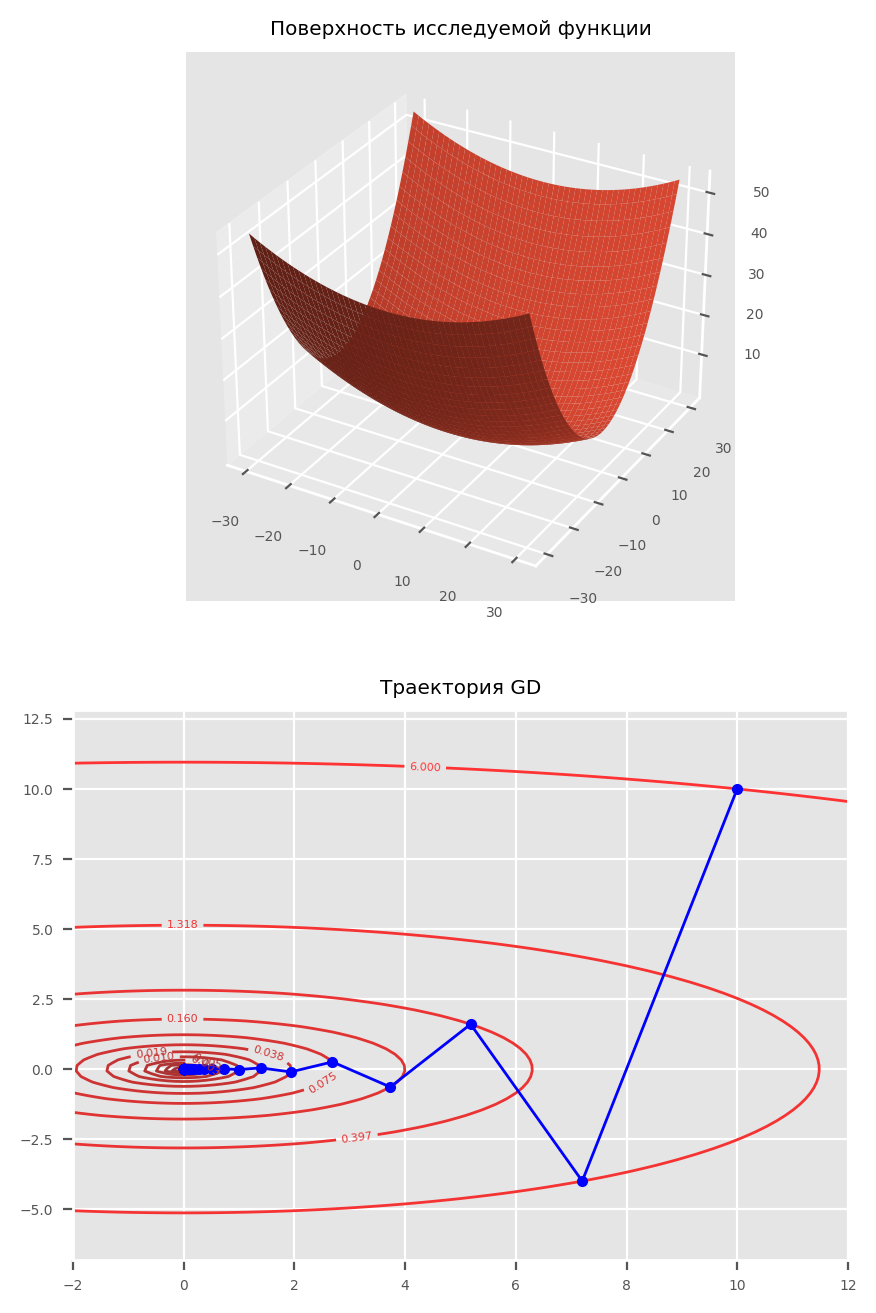

Полученный минимум: 3.97992112023532e-22
Количество итераций: 76


In [3]:
simple_function(basic_gd)

OK, все работает.

Теперь вернемся к основной цели. В этой задаче под решением (множественной) линейной регрессии будем понимать аппроксимацию заданных на плоскости точек какой-то прямой (плоскостью в случае множественной регрессии). Для запуска градиентного спуска нужна формула, которую хотим минимизировать. Назовем такую функцию функцией ошибки и в качестве нее будем использовать сумму квадратных отклонений и L2-регуляризацию.

##### В качестве датасета будем использовать вот [этот файл](https://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt) со слегка измененным форматом, описывающий массу мозга и массу тела млекопитающих.

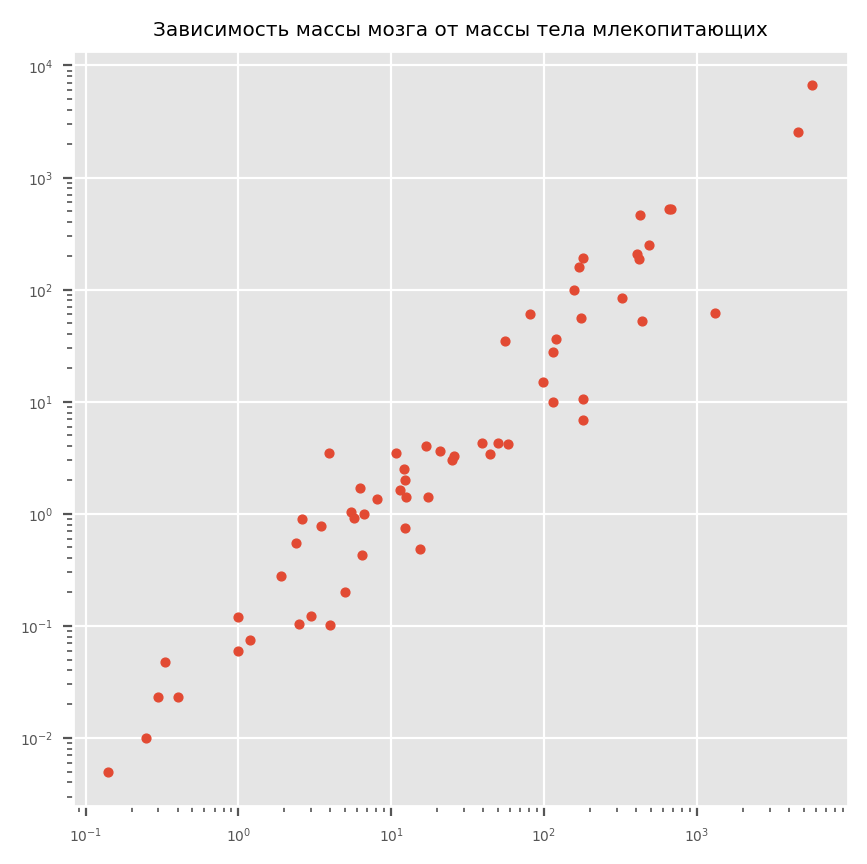

In [4]:
try:
    brains_and_weight_plot()
except FileNotFoundError:
    print("upload x01.txt and try again")

#### Функции, необходимые для решения (множественной) линейной регрессии:

In [5]:
from utils.graphics_linear_regression import *

#### Решение линейной регрессии для графика выше:

Значения функции ошибки:
[12842465.863460263, 6900445.193956978, 6441473.585152911]
Результаты методов:
[array([0.55329285, 0.07888104]), array([0.79863922, 0.04015894]), array([ 0.88669005, -3.47577211])]
Количество итераций:
[738, 1001, 1001]
Точек всего: 62
Точек взято в minibatch: 20


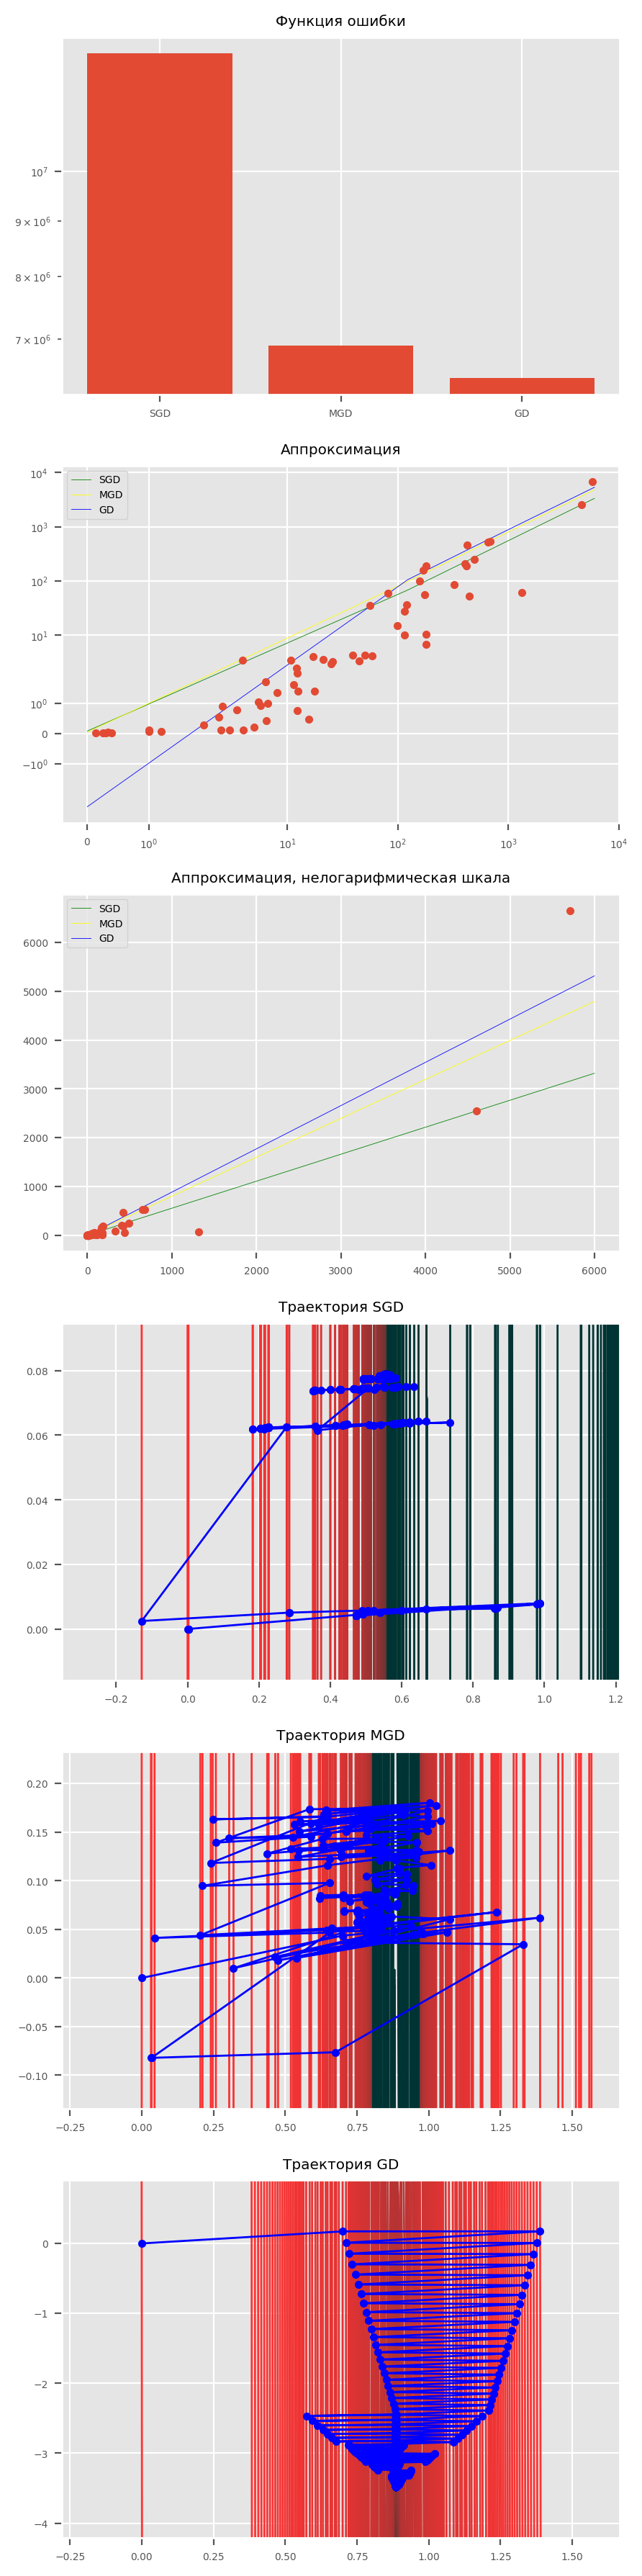

In [6]:
def brains_and_weight_solve(mover=None, lr=0.000007, points=None, show=True, bounds=(1e-4, 6000), get_points=False, alpha=1):
    if points is None:
        points = brains_and_weight_points()
    n = len(points)

    def f(*args):
        return error_l2(points, args, alpha)

    def grad_f(batch_count=n):
        return GradErrorL2(points, alpha, batch_count)

    x0 = np.zeros(len(points[0][0]) + 1)

    if isinstance(lr, float):
        lr = [lr, lr, lr]
        
    if mover is None:
        coeff = 17
        mover = [basic_exp_mover_factory(a, coeff, clip_val=1e5) for a in lr]
    
    if not isinstance(mover, list):
        mover = [mover, mover, mover]

    points_sgd = basic_gd(grad_f(1), x0, lr[0], mover=mover[0])
    points_mgd = basic_gd(grad_f(n // 3), x0, lr[1], mover=mover[1])
    points_gd = basic_gd(grad_f(), x0, lr[2], mover=mover[2])

    if show:
        ax1, ax2, ax3, ax4, ax5, ax6 = plt.figure(figsize=(5, 23)).subplots(nrows=6, ncols=1)
        basic_error_chart(ax1, f, points_sgd[-1], points_mgd[-1], points_gd[-1])

        t = np.linspace(*bounds)
        basic_approx_plot(ax2, points, t, points_sgd, points_mgd, points_gd)
        basic_approx_plot(ax3, points, t, points_sgd, points_mgd, points_gd, log=False)

        basic_log_stats(f, n, n // 3, points_sgd, points_mgd, points_gd)

        add_labels = False
        plot_contours_new(ax4, points_sgd, f, "SGD", add_labels=add_labels)
        plot_contours_new(ax5, points_mgd, f, "MGD", add_labels=add_labels)
        plot_contours_new(ax6, points_gd, f, "GD")
        plt.show()
    
    if get_points:
        return [p[-1] for p in [points_sgd, points_mgd, points_gd]]
    return [f(*p[-1]) for p in [points_sgd, points_mgd, points_gd]]


try:
    brains_and_weight_solve()
except FileNotFoundError:
    print("upload x01.txt and try again")

Вывод: метод GD, опираясь на функцию ошибки, оказался в константу раз лучше SGD и MGD в данном примере, несмотря на сильные колебания последних. Мы получили неплохой результат, учитывая что мы сильно выиграли на подсчете главного компонента градиентного спуска - собственно, градиента. Идея оказалась неплохой, и улучшение SGD будет тщательнее рассматриваться в задании 3.

##### Теперь рассмотрим другой датасет, где независимых переменных две. [оригинальный файл лежит здесь](https://people.sc.fsu.edu/~jburkardt/datasets/regression/x06.txt). Попробуем описать линейную зависимость длины рыбы от ее возраста и температуры воды в градусах Цельсия.

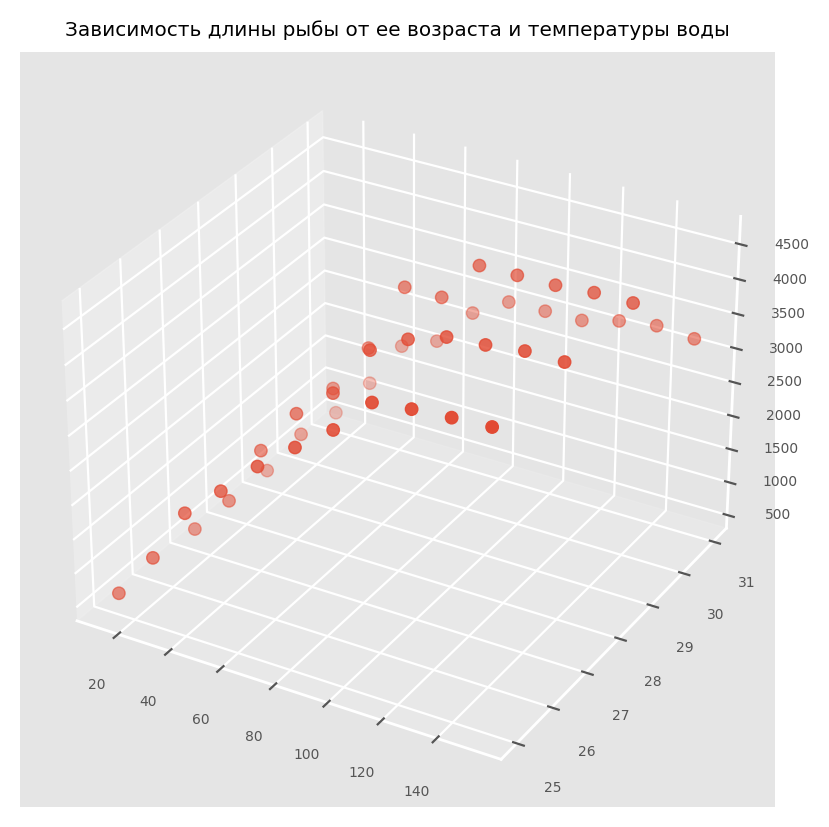

In [7]:
try:
    fish_plot()
except FileNotFoundError:
    print("upload x06.txt and try again")

#### Наша задача провести плоскость так, чтобы функция ошибки была минимальной.

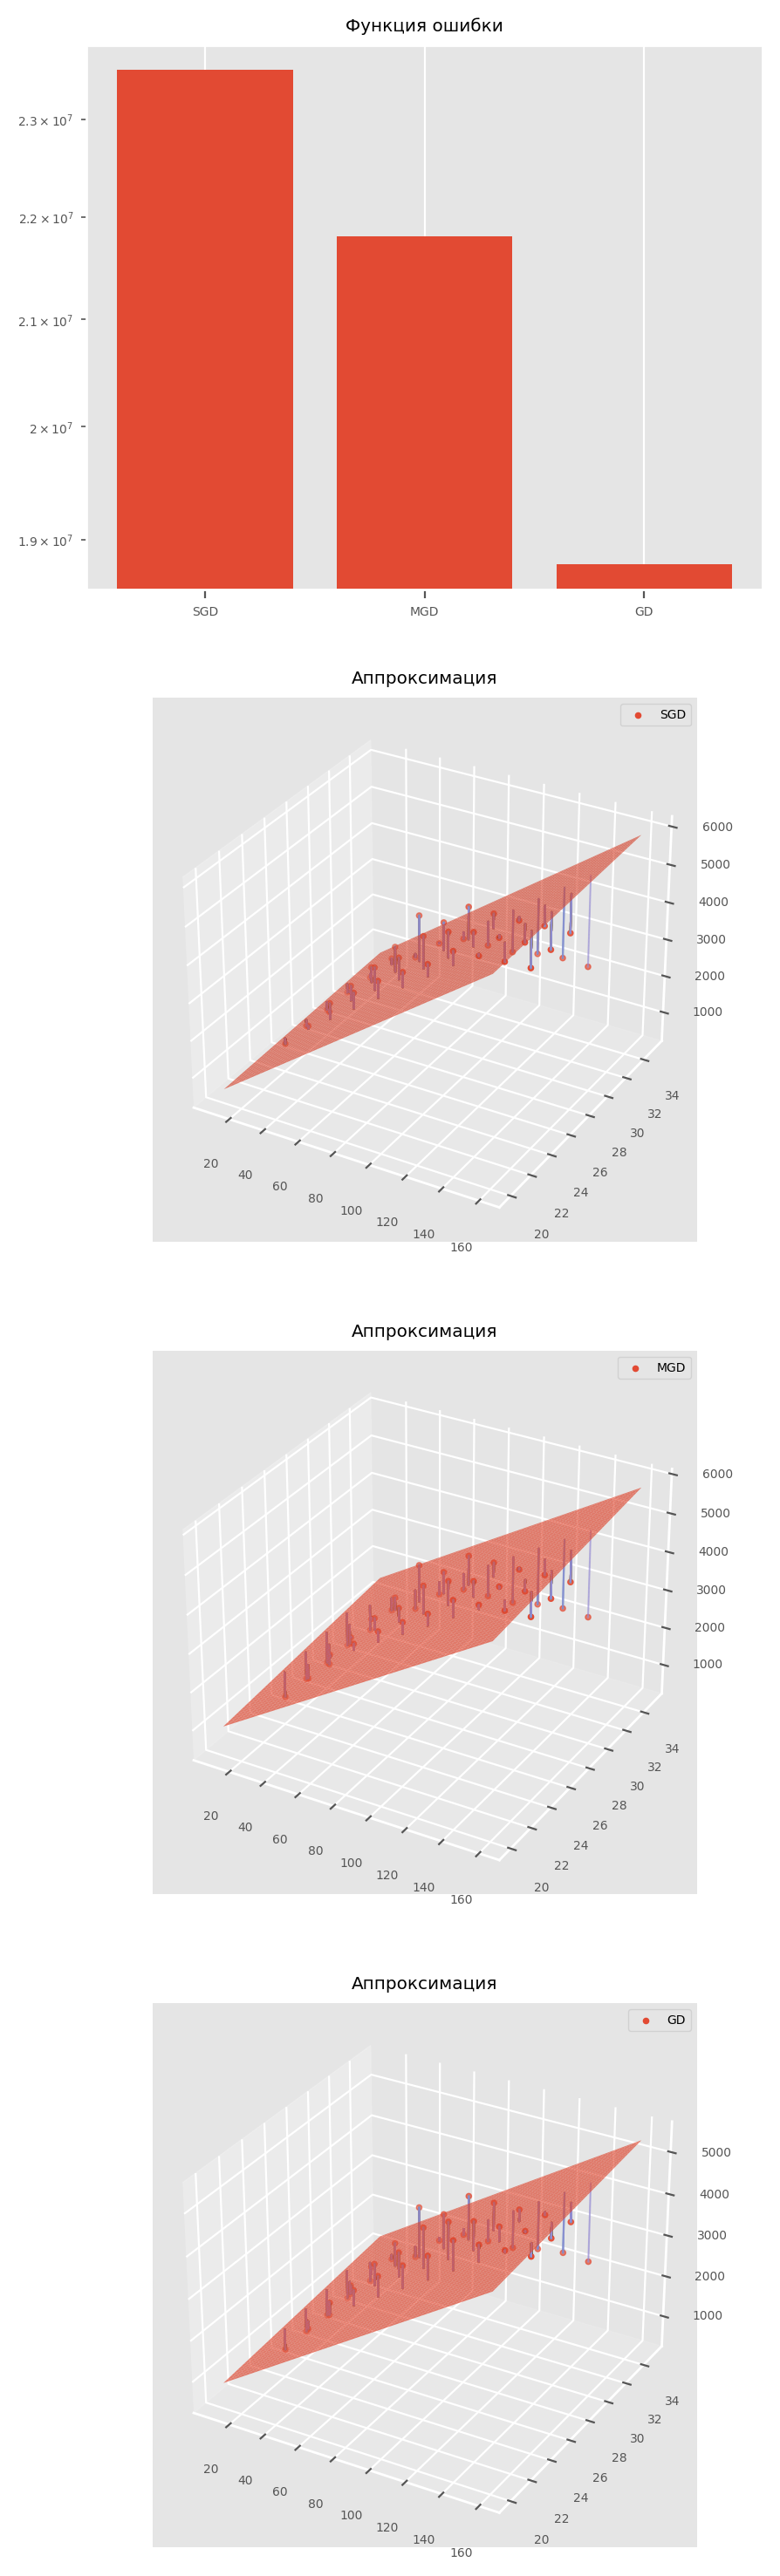

Значения функции ошибки:
[23524698.084044725, 21814032.48622282, 18787364.303455845]
Результаты методов:
[array([34.35629009,  9.60952207, 45.54587368]), array([28.38265353, 32.91091732, 57.93819735]), array([27.23668932, 26.96239236, 63.63354362])]
Количество итераций:
[655, 715, 676]
Точек всего: 44
Точек взято в minibatch: 11
Лучшее приближение:
длина рыбы в у.е. = 27.23668931570338 * возраст + 26.962392361876294 * температура воды + 63.63354362418359


In [40]:
def fish_solve(mover=None, lr=0.005, show=True, stop_cond=None):
    points = fish_points()
    n = len(points)
    alpha = 1

    def f(*args):
        return error_l2(points, args, alpha)

    def grad_f(batch_count=n):
        return GradErrorL2(points, alpha, batch_count)

    x0 = np.zeros(len(points[0][0]) + 1)

    if mover is None:
        coeff = 40
        mover = [basic_exp_mover_factory(lr, coeff, clip_val=1e4) for i in range(3)]
    
    if stop_cond is None:
        stop_cond = basic_stop_cond_factory()
    
    if not isinstance(mover, list):
        mover = [mover, mover, mover]

    points_sgd = basic_gd(grad_f(1), x0, lr, mover=mover[0], stop_cond=stop_cond)
    points_mgd = basic_gd(grad_f(n // 4), x0, lr, mover=mover[1], stop_cond=stop_cond)
    points_gd = basic_gd(grad_f(), x0, lr, mover=mover[2], stop_cond=stop_cond)

    if show:
        fig = plt.figure(figsize=(5, 19))
        ax1 = fig.add_subplot(4, 1, 1)
        ax2 = fig.add_subplot(4, 1, 2, projection='3d')
        ax3 = fig.add_subplot(4, 1, 3, projection='3d')
        ax4 = fig.add_subplot(4, 1, 4, projection='3d')

        basic_error_chart(ax1, f, points_sgd[-1], points_mgd[-1], points_gd[-1])

        tx = np.linspace(10, 160, 100)
        ty = np.linspace(20, 35, 100)

        ax2.view_init(30, None)
        ax3.view_init(30, None)
        ax4.view_init(30, None)

        basic_approx_plot_3d(ax2, points, tx, ty, points_sgd, "SGD")
        basic_approx_plot_3d(ax3, points, tx, ty, points_mgd, "MGD")
        basic_approx_plot_3d(ax4, points, tx, ty, points_gd, "GD")
        plt.show()

        basic_log_stats(f, n, n // 4, points_sgd, points_mgd, points_gd)

        lowest_error = np.Inf
        best = None

        for i in [points_sgd[-1], points_mgd[-1], points_gd[-1]]:
            err = f(*i)
            if err < lowest_error:
                lowest_error = err
                best = i

        print("Лучшее приближение:")
        print("длина рыбы в у.е. = {0} * возраст + {1} * температура воды + {2}".format(*best))
        
    else:
        return [f(*p[-1]) for p in (points_sgd, points_mgd, points_gd)]


try:
    fish_solve()
except FileNotFoundError:
    print("upload x06.txt and try again")

Мы реализовали три алгоритма градиентного спуска, подготовили инструментарий и научились базово решать задачу линейной регрессии. Пока что SGD отстает от GD и как следует из графиков сильно осциллирует.

Есть несколько способов исправить положение и показать SGD в выгодном свете на фоне конкурентов.

## Задание 2.

Исследовать влияние предварительной нормализации(scaling) данных на сходимость

Возьмем для примера как входные данные вытянутую параболу, запустим на ней градиентный спуск

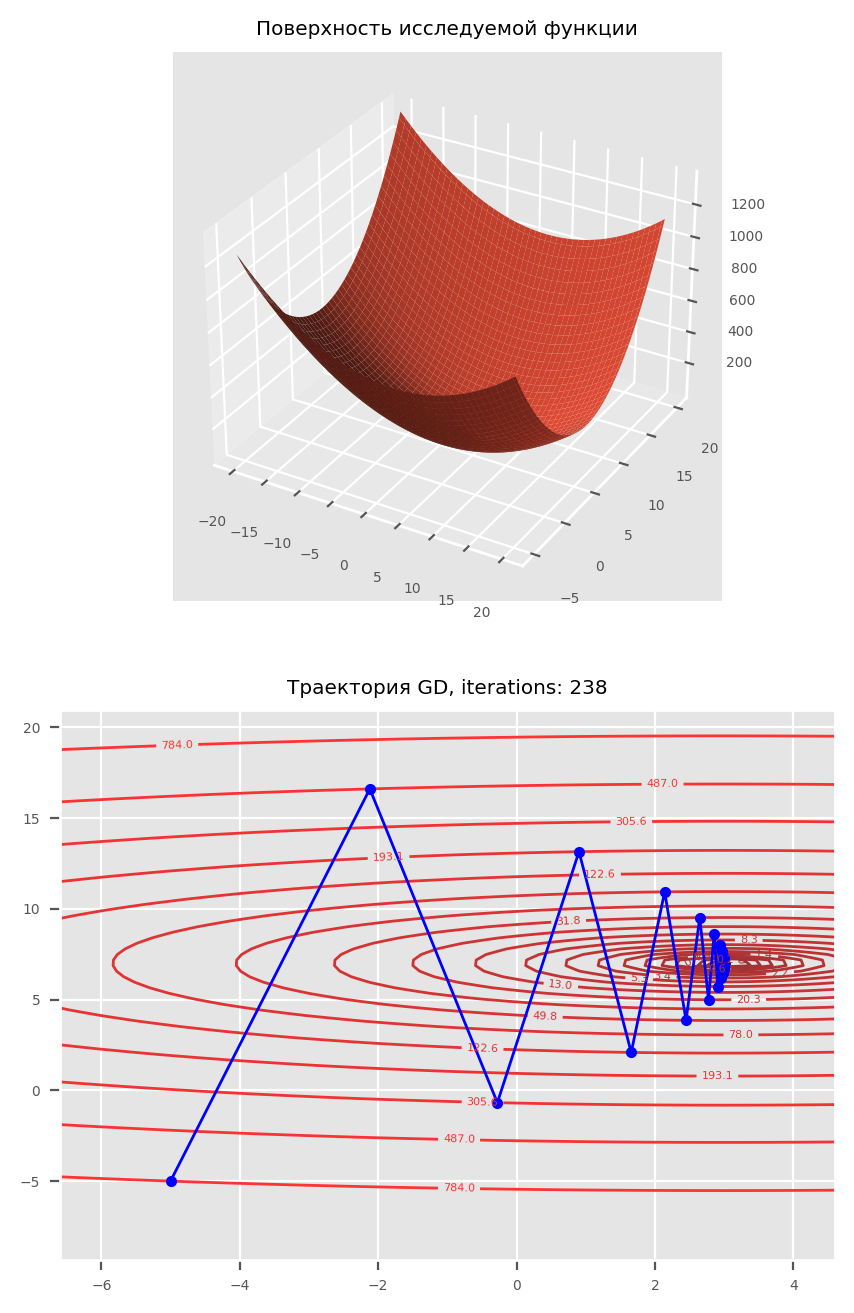

In [9]:
def func123(x, y):
    return (x-3)*(x-3) + 5*(y-7)*(y-7)


def universal_grad_2D(f, eps1=0.00001):
    return lambda x, y: ((f(x + eps1, y) - f(x, y)) / eps1, (f(x, y + eps1) - f(x, y)) / eps1)

def draw_3d(f, ax, x_bounds=(-20, 20), y_bounds= (-20, 20), title="Функция без скейла"):
    t_x = np.linspace(*x_bounds, 100)
    t_y = np.linspace(*y_bounds, 100)
    X, Y = np.meshgrid(t_x, t_y)
    ax.set_title(title, color='black')
    ax.plot_surface(X, Y, f(X, Y))


def draw_3d_and_circles(ax1, ax2, pts, f, x_bounds=(-20, 20), y_bounds=(-20, 20), support=False):
    t_x = np.linspace(*x_bounds, 100)
    t_y = np.linspace(*y_bounds, 100)
    X, Y = np.meshgrid(t_x, t_y)

    basic_3d_plot2(ax1, f, X, Y, title="Поверхность исследуемой функции")

    if support:
        ax2.set_title("iterations: {0}".format(pts.size), color='black')
        ax2.plot(pts[:, 0], pts[:, 1], 'o-')
        ax2.contour(X, Y, f(X, Y), levels=sorted([f(*p) for p in pts]))
    else:
        plot_contours_new(ax2, pts, f, "GD, iterations: {0}".format(pts.size), add_labels=True)


def task2a():
    u_g = universal_grad_2D(func123)
    pts = basic_gd(u_g, np.array([-5, -5]), 0.18)

    fig = plt.figure(figsize=(5, 8))
    ax1 = fig.add_subplot(2, 1, 1, projection='3d')
    ax2 = fig.add_subplot(2, 1, 2)

    draw_3d_and_circles(ax1, ax2, pts, func123, (-20, 20), (-5, 20))
    plt.show()

task2a()

заметим, что при не очень удачном learning rate градиентный спуск скачет по сторонам параболы, при этом сходясь очень медленно (целых 238 итераций потребовалось)

применим на наших входных данных min-max scaling, для того чтобы оба аргумента функции вносили примерно одинаковый вклад в ее рост(по сути это позволяет сделать параболу менее вытянутой), далее запустим на ней градиентный спук из той же точки но сдвинутой c помощью min_max, а так же соотсвесвтенно уменьшемнным leaning_rate

Новая позиция начала: [0.375, 0.0] новый learning rate: 0.000225


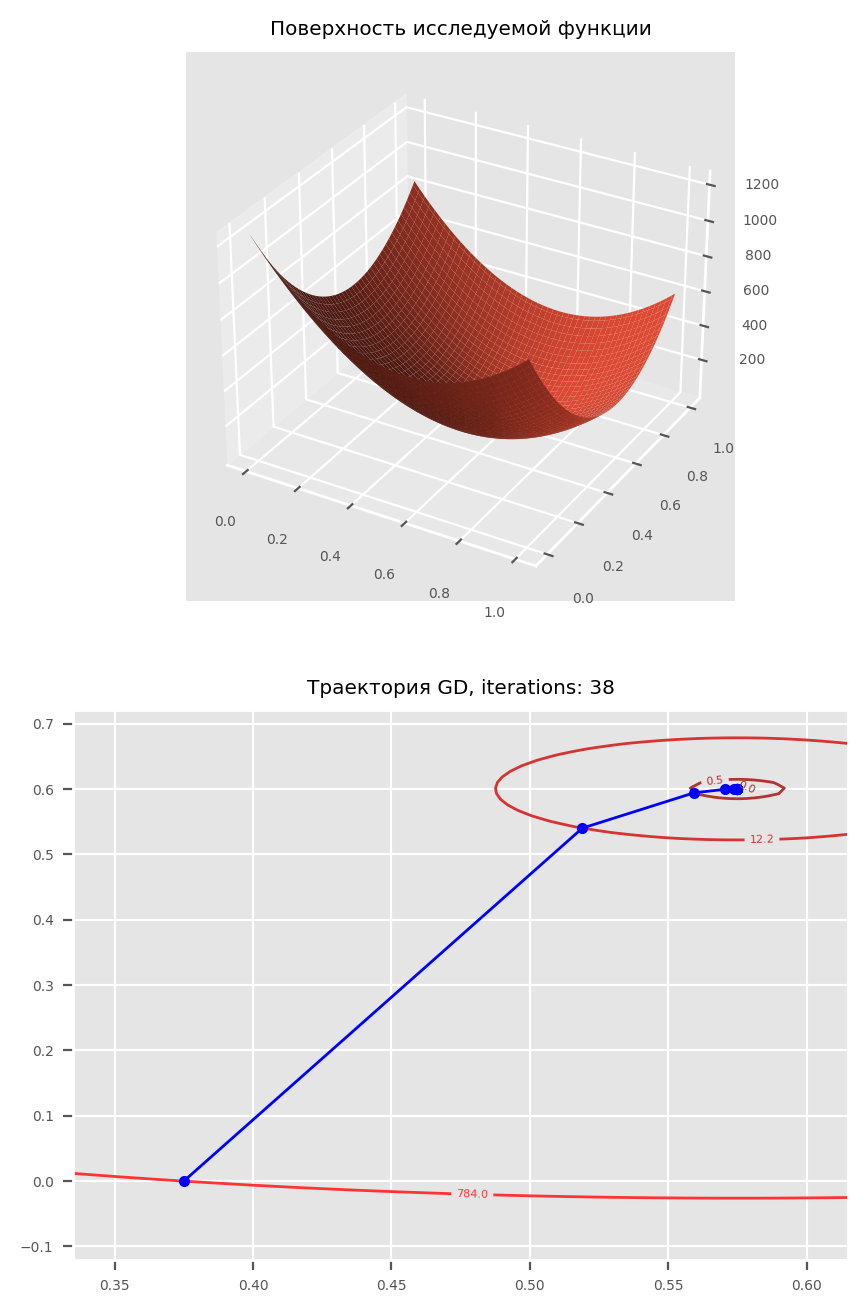

In [10]:
def min_max_norm_reversed_arg(min, max):
    return lambda x: x * (max - min) + min


def min_max_norm_reversed(f, x_bounds, y_bounds):
    rev_x = min_max_norm_reversed_arg(*x_bounds)
    rev_y = min_max_norm_reversed_arg(*y_bounds)
    return lambda x, y: f(rev_x(x), rev_y(y))

def min_max_point(p, x_bounds, y_bounds):
    min_max = lambda a, bounds: (a - bounds[0]) / (bounds[1] - bounds[0])
    return [min_max(p[0], x_bounds), min_max(p[1], y_bounds)]


def task2b():
    func123_r = min_max_norm_reversed(func123, (-20, 20), (-5, 15))
    u_g = universal_grad_2D(func123_r, 0.000001)
    start = min_max_point([-5, -5], (-20, 20), (-5, 15))
    new_lr = 0.18/40/20
    pts = basic_gd(u_g, np.array(start),new_lr)
    print("Новая позиция начала:",start, "новый learning rate:", new_lr)

    fig = plt.figure(figsize=(5, 8))
    ax1 = fig.add_subplot(2, 1, 1, projection='3d')
    ax2 = fig.add_subplot(2, 1, 2)
    draw_3d_and_circles(ax1, ax2, pts, func123_r, (0, 1), (0, 1))
    plt.show()

task2b()

Можем заметить, что после применения скейлинга исходные данные(парабола) приобрели более подходящий для градиентного спуска вид, количество итераций значительно уменьшилось 238 -> 38

Далее попробуем примений такой же подход для очень вытянутой функции ошибки из первого задания, возможно у нас получится быстрее приблизиться к ее миниммуму:

6283176.784645026


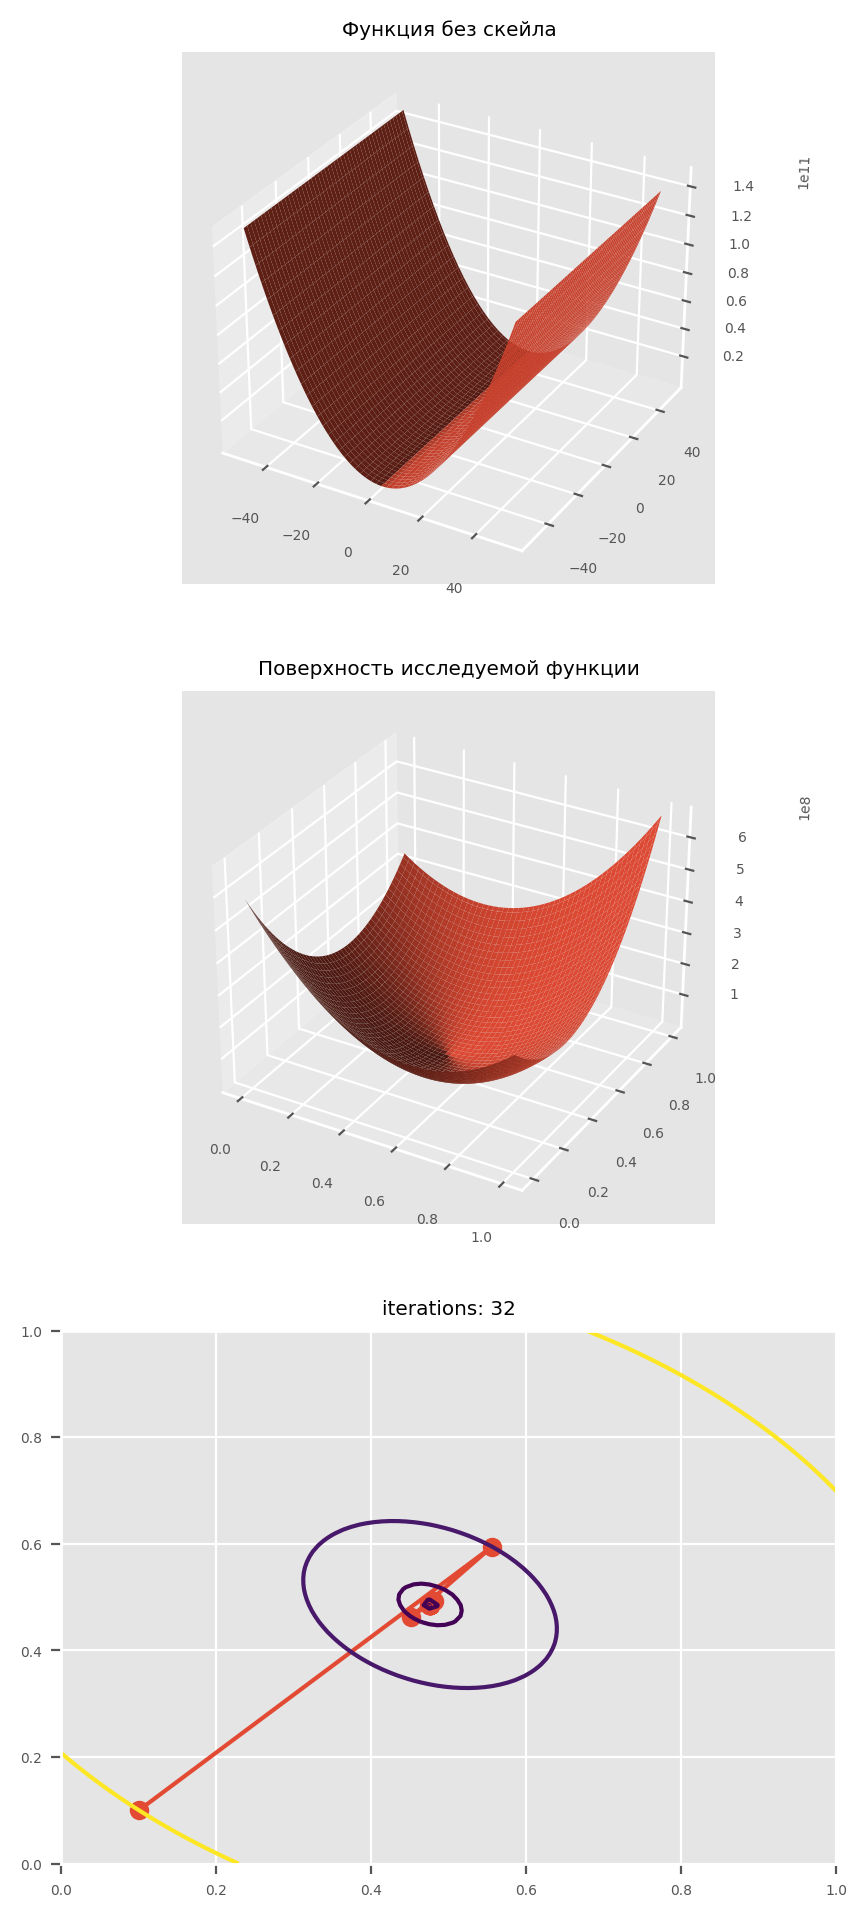

In [11]:
def task2c():
    points = np.array(brains_and_weight_points(), dtype=object)

    def error(*coefs):
        return error_l2(points, coefs)


    fig = plt.figure(figsize=(5, 12))
    ax1 = fig.add_subplot(3, 1, 1, projection='3d')
    ax2 = fig.add_subplot(3, 1, 2, projection='3d')
    ax3 = fig.add_subplot(3, 1, 3)

    draw_3d(error, ax1, (-50, 50), (-50, 50))

    func = min_max_norm_reversed(error, (-1, 3), (-2000, 2000))
    u_g = universal_grad_2D(func, 0.000000001)
    pts = basic_gd(u_g, np.array([0.1,0.1]), 0.0000000005, eps=0.0001)

    print(func(*pts[-1]))
    draw_3d_and_circles(ax2, ax3, pts, func, (0, 1), (0, 1), support=True)

task2c()

У нас получилось! Благодаря скейлингу функции ошибки нам удалось получить ~тот же минимум за 38 итераций вместо 800+ в начале
Так происходит, потому что функция ошибки изначатльно очень сильно вытянутая, но мы смогли ее преобразовать в достаточно округлую параболу.

Так же попробуем применить стандартизацию (Z-Score Normalization) к изначальному датасету:

Значения функции ошибки:
[7.890321770824033, 7.610647983627679, 7.609987200843049]
Результаты методов:
[array([0.96228197, 0.02974585]), array([ 0.90477858, -0.0026583 ]), array([9.02912509e-01, 9.26833757e-17])]
Количество итераций:
[869, 1001, 409]
Точек всего: 62
Точек взято в minibatch: 20


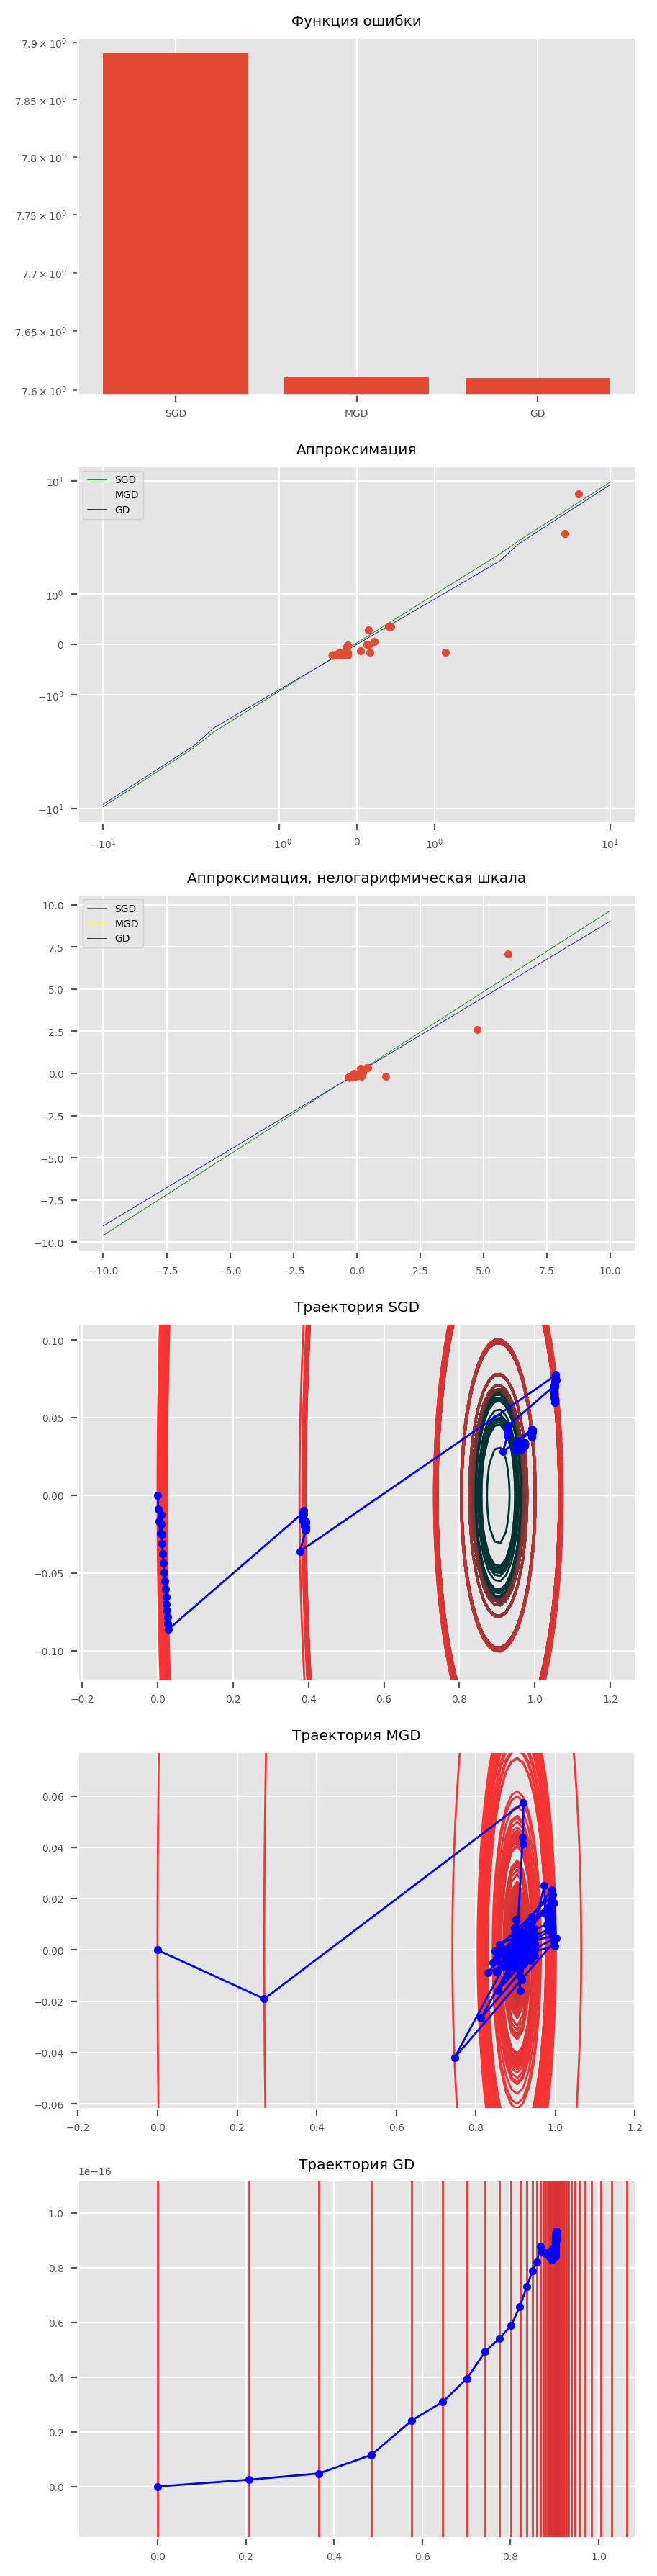

Полученные функциb: [array([0.96228197, 0.02974585]), array([ 0.90477858, -0.0026583 ]), array([9.02912509e-01, 9.26833757e-17])]


In [12]:
def task2d():
    points = brains_and_weight_points()

    pts = np.array(points, dtype=object)
    x_s = np.array([i[0] for i in pts[:, 0]])
    y_s = pts[:, 1]
    pts = []
    for i in range(x_s.size):
        pts.append([x_s[i], y_s[i]])
    pts = np.array(pts)

    def mean_norm_value(vec, mean, avg):
        return (vec - avg) / mean

    def mean_normalize(pts): 
        mean = pts.std()
        avg = np.average(pts, axis=0)
        return np.array([mean_norm_value(v, mean, avg) for v in pts])

    mean_pts=mean_normalize(pts)
    mean_pts = [(np.array([v[0]]), v[1]) for v in mean_pts ]
    ans = brains_and_weight_solve(points=mean_pts, lr=( 0.02, 0.01, 0.0018), bounds=(-10, 10), get_points=True, alpha=0)
    print("Полученные функциb:", ans)
    
task2d()


Можем заметить, что стандартизация увеличила скорость сходимости GD и SGD. 

Вывод: scaling с помощью min_max может значительно увеличисть скорость сходимости градиентного скупска на вытянутых функциях, однако он требует знание отношений перменных между собой (например полезно знать что x вносит в 10 раз больше вклада чем y, для жизненных задач такое часто встречается, когда в функции у нас на равных правах находятся площадь квартиры в м^2 и количество комнат).
Стандартизация может помочь избавиться от выбивающихся из ряда значений, что позволяет облегчить процесс приблежения их к прямой (ускорить сходимость градиентных спусков)

## Задание 3.

Одна из проблем наивной реализации стохастического спуска - это осцилляция (явление, которое возникает, когда значение функции существенно не меняется, независимо от того, в каком направлении она движется, т.е., например, когда по одному направлению спуск происходит быстро, а по другому - медленно), вследствие чего сходимость к минимуму становится крайне медленной. Для решения этой проблемы были разработаны модификации SGD, исследованием которых мы займемся в этом задании.

### 1) Momentum
Идея модификации: увеличивать шаг по направлению к минимуму. Это достигается за счёт того, что сдвиг параметров расчитывается как взвешенная сумма сдвига на предыдущем шаге и нового на основе градиента:

$g_{new} = \beta * g_{prev} + (1 - \beta) * direction$,

$x_{new} = x_{prev} - lr * g_{new}$

In [13]:
class MomentumMover:
    g_prev = None

    def __call__(self, x, lr, grad, **kwargs):
        if self.g_prev is None:
            self.g_prev = np.zeros(len(x))
        g_new = self.b * self.g_prev + (1 - self.b) * np.array(grad(*x))
        self.g_prev = g_new
        return x - lr * g_new, lr

    def __init__(self, b):
        self.b = b

In [14]:
def func1(x, y):
    return 5 * (x + 10) ** 2 + (y - 11) ** 2


def grad_func1(x, y):
    return 10 * (x + 10), 2 * (y - 11)


func1_x0 = np.array([-20, -20])

Число шагов: 509
Результат: 1.1644310964979172e-20
[3.248356644692654e-20, 2.9316078671290976e-20, 2.645814865544297e-20, 2.3877926755645724e-20, 2.1550003825250945e-20, 1.9448767664813332e-20, 1.755198658052473e-20, 1.584036793765156e-20, 1.4296217018109866e-20, 1.2902426095215264e-20, 1.1644310964979172e-20]


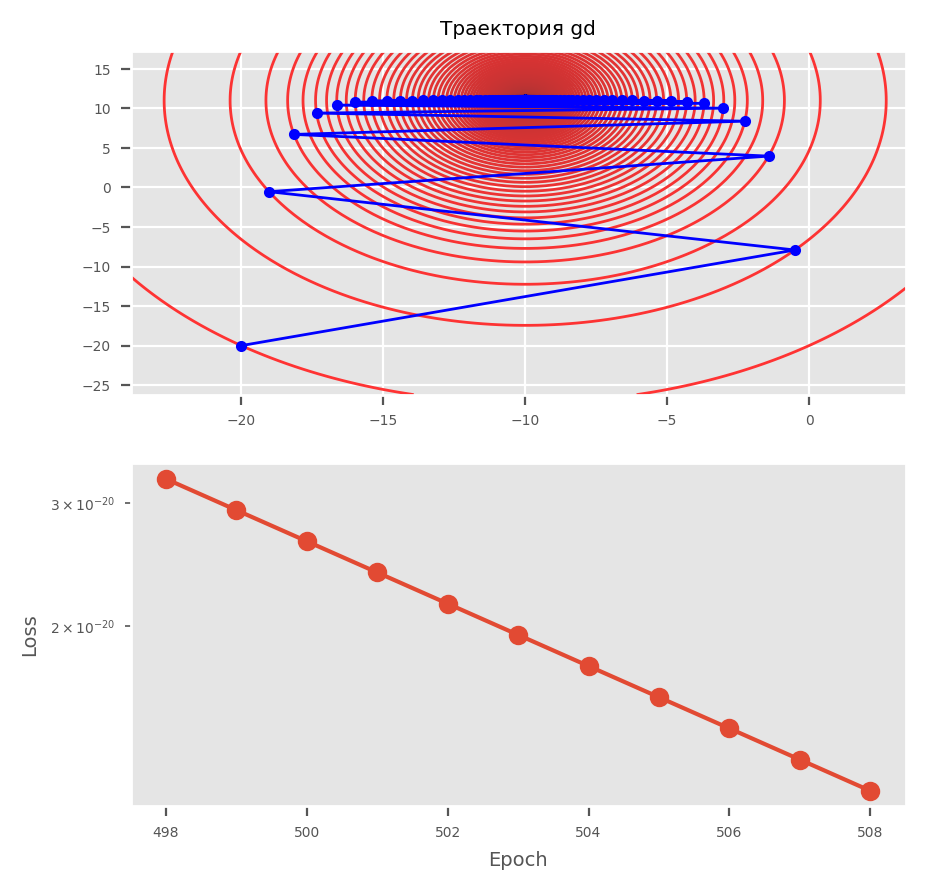

In [15]:
def task2_momentum(mover=basic_mover, lr=0.195):
    points_gd = basic_gd(grad_func1, func1_x0, lr, mover=mover)

    print("Число шагов:", len(points_gd))
    print("Результат:", func1(*points_gd[-1]))

    ax1, ax2 = plt.subplots(nrows=2, ncols=1)[1]
    plot_contours_new(ax1, points_gd, func1, "gd")
    plot_loss_epoch(ax2, points_gd, func1)
    plt.show()


task2_momentum()

Число шагов: 54
Результат: 5.294898167359009e-22
[4.750927298418112e-17, 1.537435168241716e-17, 2.4500483189585734e-18, 7.149254030825474e-19, 3.322328306902349e-20, 1.2568546897016803e-19, 4.714101545429082e-20, 3.488247504165485e-20, 9.61431656467936e-21, 3.972020393548087e-21, 5.294898167359009e-22]


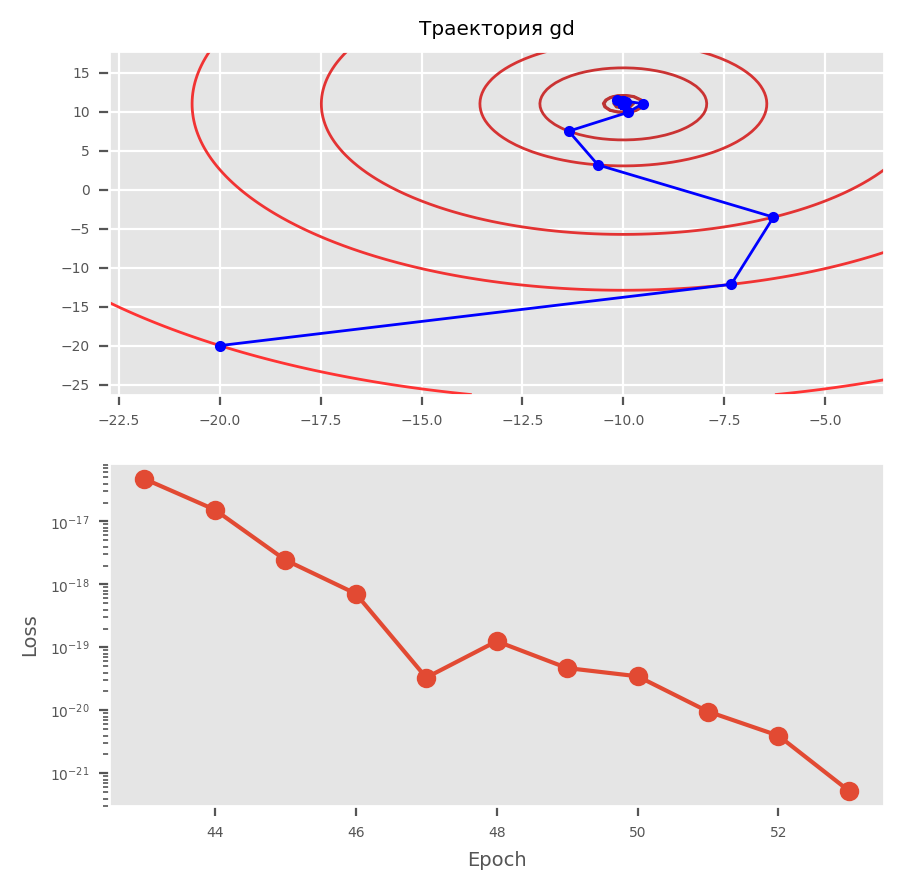

In [16]:
task2_momentum(mover=MomentumMover(0.35))

Видно, что при неудачном выборе lr метод моментов позволяет ускорить сходимость, в разы снижая количество необходимых шагов; при этом можно добиться лучшей сходимости.
Убедимся, что и для оптимального в случае константного спуска lr метод позволяет сократить количество необходимых шагов и улучшить сходимость:

Число шагов: 75
Результат: 5.937962948658552e-21
[7.446737979011279e-18, 3.648487860758562e-18, 1.7875827673745597e-18, 8.758349886602102e-19, 4.2912363894440737e-19, 2.1025703312569975e-19, 1.0302043261170524e-19, 5.0476804384804227e-20, 2.4732392978282297e-20, 1.2118770709558407e-20, 5.937962948658552e-21]


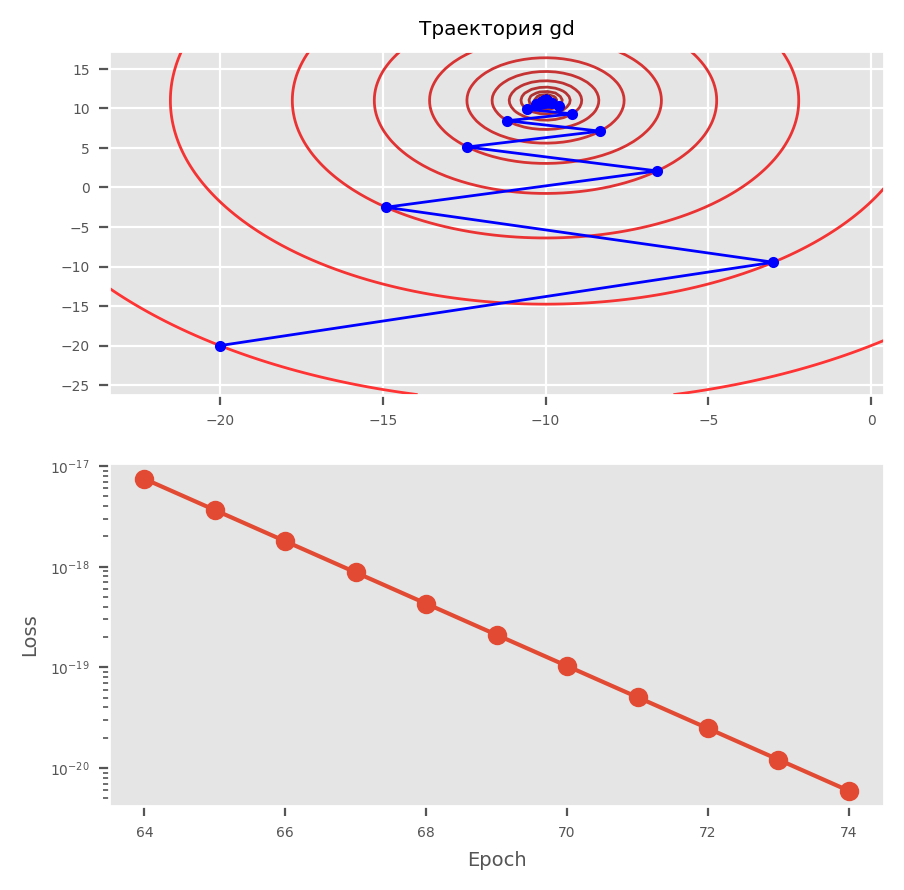

In [17]:
task2_momentum(lr=0.17)

Число шагов: 56
Результат: 1.6535052545414497e-20
[2.466778239735341e-16, 9.435351878870231e-17, 3.6089931496886616e-17, 1.3804286166845546e-17, 5.280093801502502e-18, 2.019620234830531e-18, 7.724973279700995e-19, 2.954785681390149e-19, 1.1301995997493751e-19, 4.3229578265599164e-20, 1.6535052545414497e-20]


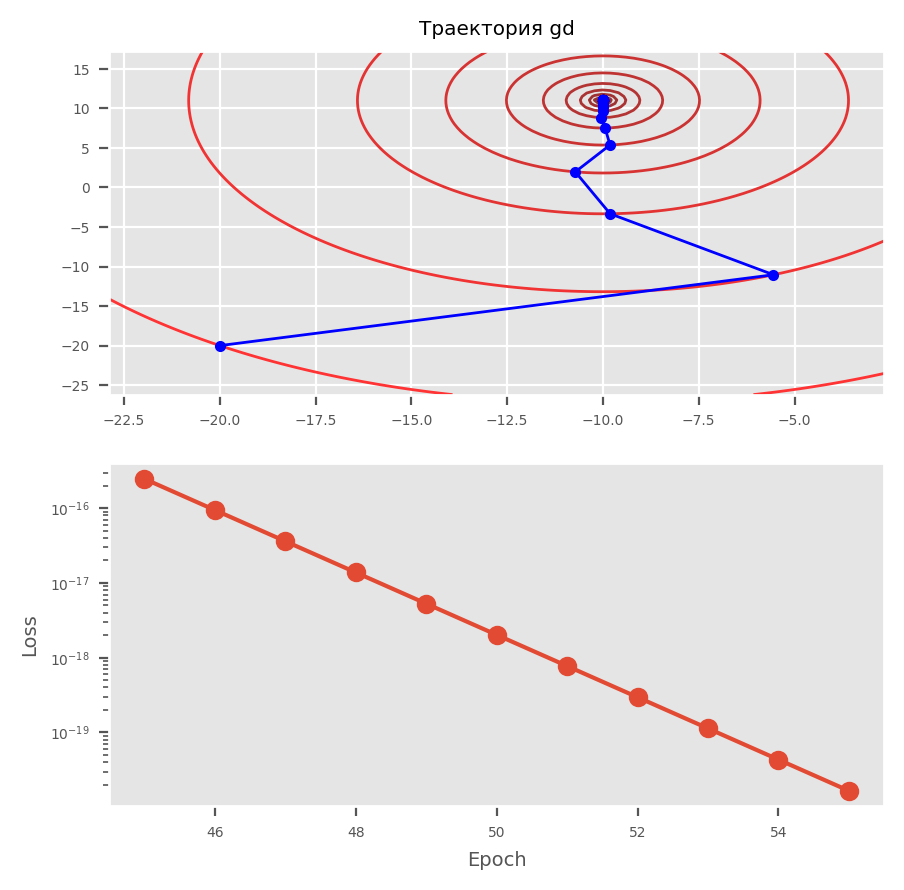

In [18]:
task2_momentum(mover=MomentumMover(0.15), lr=0.17)

Значения функции ошибки:
[6463505.038769288, 6466815.8106436925, 6463091.697122776]
Результаты методов:
[array([8.88030563e-01, 5.47335454e-05]), array([ 0.89360322, -0.0038072 ]), array([ 0.88563754, -0.01259697])]
Количество итераций:
[1001, 1001, 1001]
Точек всего: 62
Точек взято в minibatch: 20


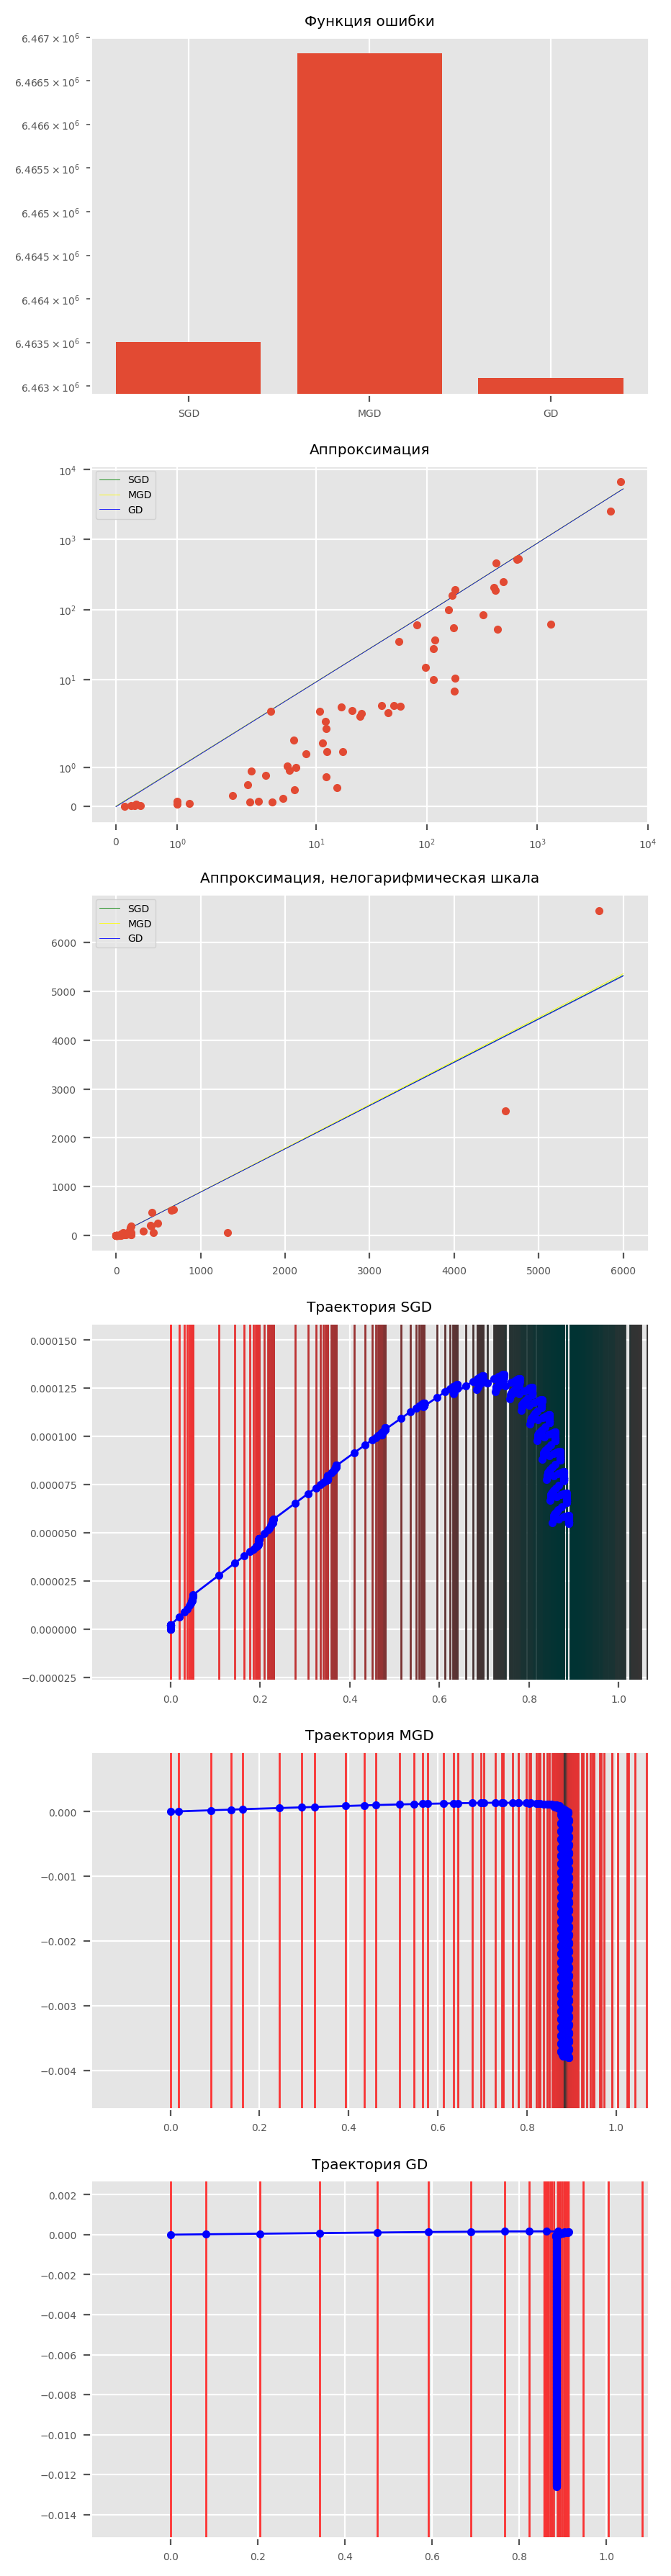

[6463505.038769288, 6466815.8106436925, 6463091.697122776]

In [19]:
brains_and_weight_solve([MomentumMover(0.6),MomentumMover(0.6),MomentumMover(0.6)], lr=0.000000002)

### 2) Nesterov
Вместо того чтобы высчитывать градиент в текущей точке, будем использовать градиент в точке “предсказанной” на основании сдвига, расчитанного на предыдущем шаге:

$g_{new} = \beta * g_{prev} + lr * grad(x - \beta * g_{prev})$,

$x_{new} = x_{prev} - g_{new}$

https://vbystricky.github.io/2018/03/optimization_grad_desc.html#%D0%BC%D0%BE%D0%BC%D0%B5%D0%BD%D1%82%D1%8B

In [20]:
class NesterovMover:
    g_prev = 0  # not an array at first, but after 1 iteration it converts to an array
    b = 0

    def __init__(self, b):
        self.b = b

    def __call__(self, x, lr, grad, **kwargs):
        g_new = self.b * self.g_prev + lr * np.array(grad(*(x - self.b * self.g_prev)))
        self.g_prev = g_new
        return x - g_new, lr

In [21]:
def task2_nesterov(mover=basic_mover, lr=0.195):
    points_gd = basic_gd(grad_func1, func1_x0.copy(), lr, mover=mover) # eps=1e-20)
    print("Число шагов:", len(points_gd))
    print("Результат:", func1(*points_gd[-1]))

    ax = plt.subplots()[1]
    plot_contours(ax, points_gd, func1, 0, -20, 15, -20,
                  len(points_gd) < 35)  # уберите сравнение, чтобы видеть пометки контуров когда кружочков очень много
    plt.show()


# task2_nesterov(mover=MomentumMover(0.16))

Число шагов: 45
Результат: 1.2542508364321707e-19


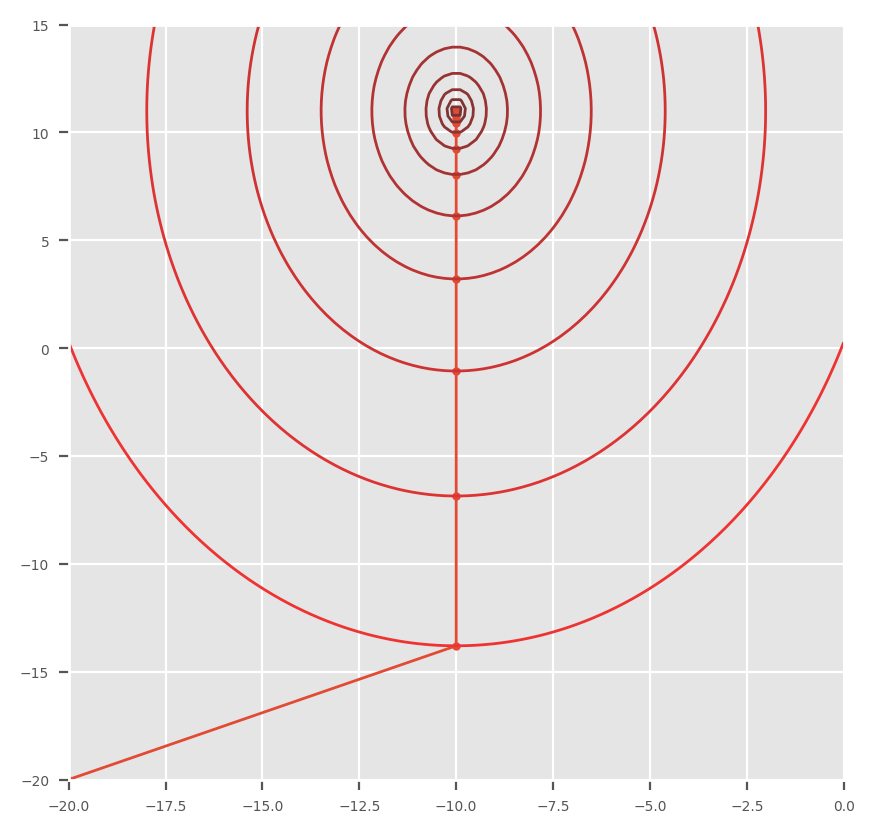

In [22]:
task2_nesterov(mover=NesterovMover(0.4), lr=0.1)

Значения функции ошибки:
[6463355.4636754505, 6463825.975090672, 6463092.319488708]
Результаты методов:
[array([8.83857436e-01, 5.64987750e-05]), array([ 0.88905953, -0.00377357]), array([ 0.88563751, -0.01250036])]
Количество итераций:
[1001, 1001, 1001]
Точек всего: 62
Точек взято в minibatch: 20


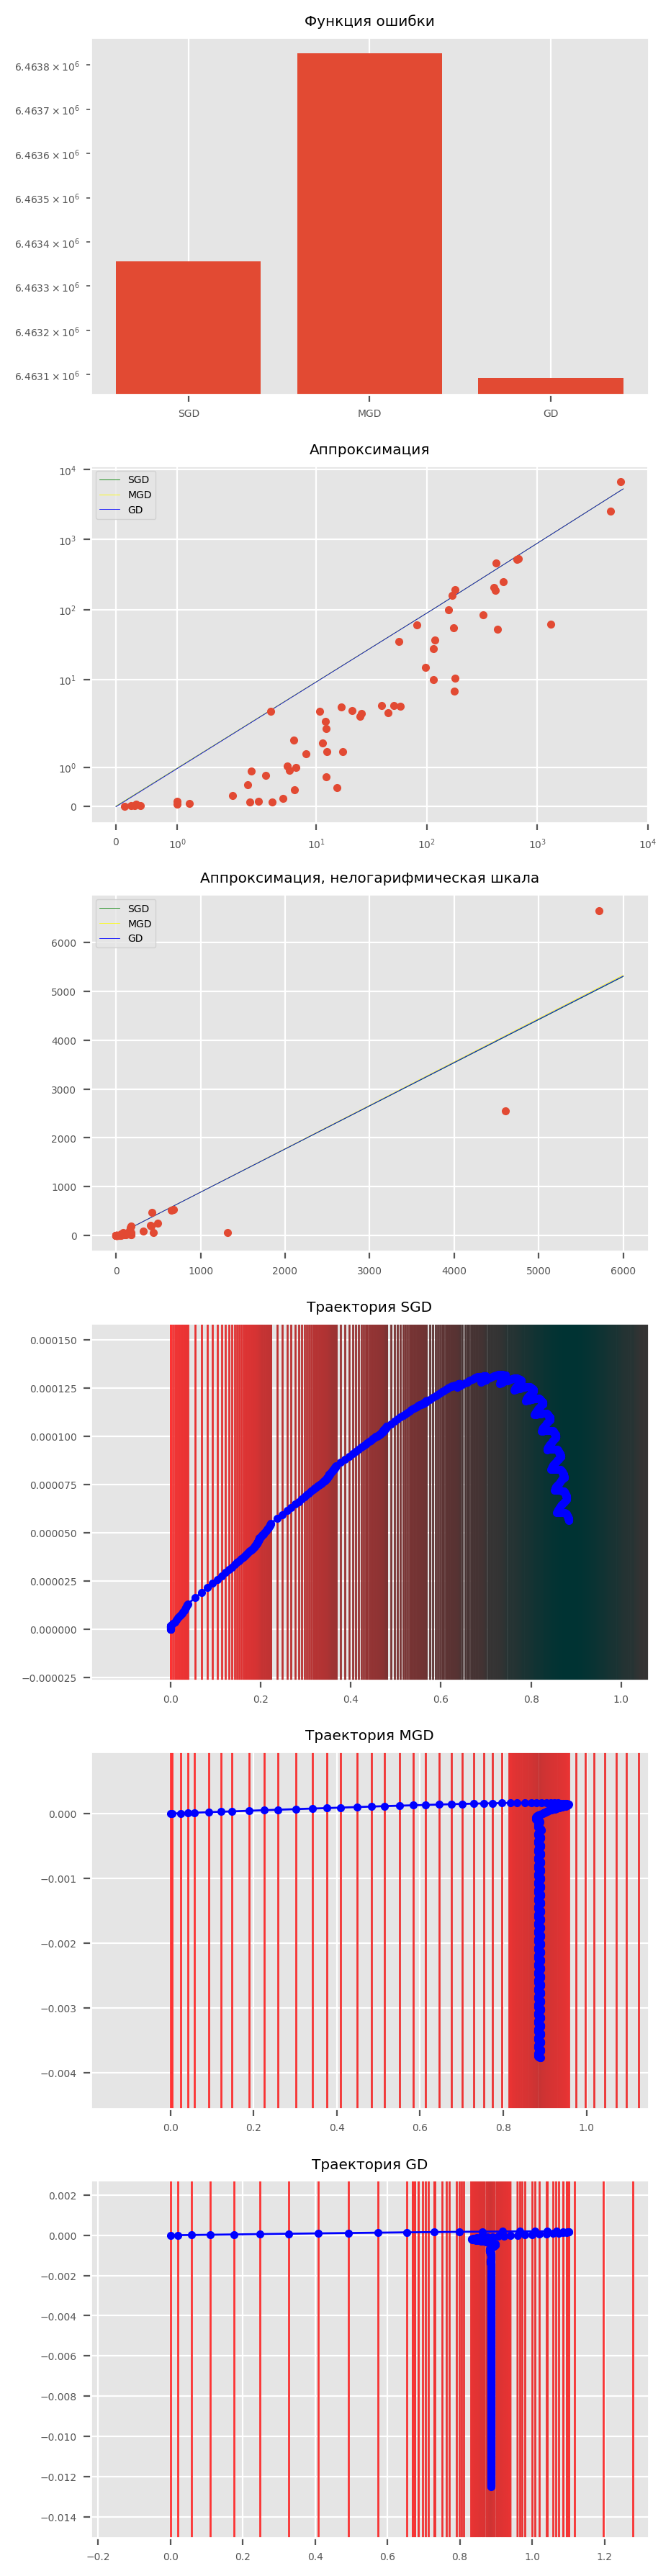

[6463355.4636754505, 6463825.975090672, 6463092.319488708]

In [23]:
brains_and_weight_solve([NesterovMover(0.9), NesterovMover(0.9), NesterovMover(0.9)], 0.0000000002)

### 3) AdaGrad
Идея модификации: подбирать скорость обучения для каждого коэффициента в зависимости от того как сильно он менялся ранее. С этой целью будем хранить для каждого параметра сумму квадратов его обновлений.
Данный метод борется с осцилляцией, не допуская ситуации, когда один параметр меняется слишком быстро.

$G_{new} = G + grad(x)^2$,

$x_{new} = x_{prev} - grad(x) * \frac{lr}{(\sqrt{g_{new}} + \epsilon)}$


In [24]:
class AdaGradMover:
    EPS = 1e-8

    def __call__(self, x, lr, grad, **kwargs):
        gr = np.array(grad(*x))
        self.G += gr ** 2
        adjusted_grad = gr / (EPS + np.sqrt(self.G))
        return x - lr * adjusted_grad, lr

    def __init__(self):
        self.x0 = 0
        self.G = 0

Лучшие результаты и соответствующий им learning rate

*   sgd: 6462875.090337068, lr=0.15945945945945947
*   mgd: 6315550.292392632, lr=5.352252252252253
*   gd: 6307484.195993495, lr=10.0

In [25]:
def adagrad_find_best():
    lrs = np.linspace(0.1, 10, 1000)
    min_sgd = [90000000, 0]
    min_mgd = [90000000, 0]
    min_gd = [90000000, 0]

    for j in range(0, len(lrs)):
        sgd, mgd, gd = brains_and_weight_solve(mover=AdaGradMover(), lr=lrs[j], show=False)
        if sgd < min_sgd[0]:
            min_sgd = [sgd, lrs[j]]
        if mgd < min_mgd[0]:
            min_mgd = [mgd, lrs[j]]
        if gd < min_gd[0]:
            min_gd = [gd, lrs[j]]

    print("Лучшие результаты и соответствующий им learning rate:")
    print(min_sgd, '\n', min_mgd, '\n', min_gd)

# лучше не запускать, т.к. считает довольно долго
# adagrad_find_best()

Значения функции ошибки:
[21686347.11857926, 6321819.813902522, 6283376.656397394]
Результаты методов:
[array([  1.40504882, -15.18480488]), array([  0.92614138, -50.22603097]), array([  0.9020457 , -54.00783621])]
Количество итераций:
[1001, 1001, 1001]
Точек всего: 62
Точек взято в minibatch: 20


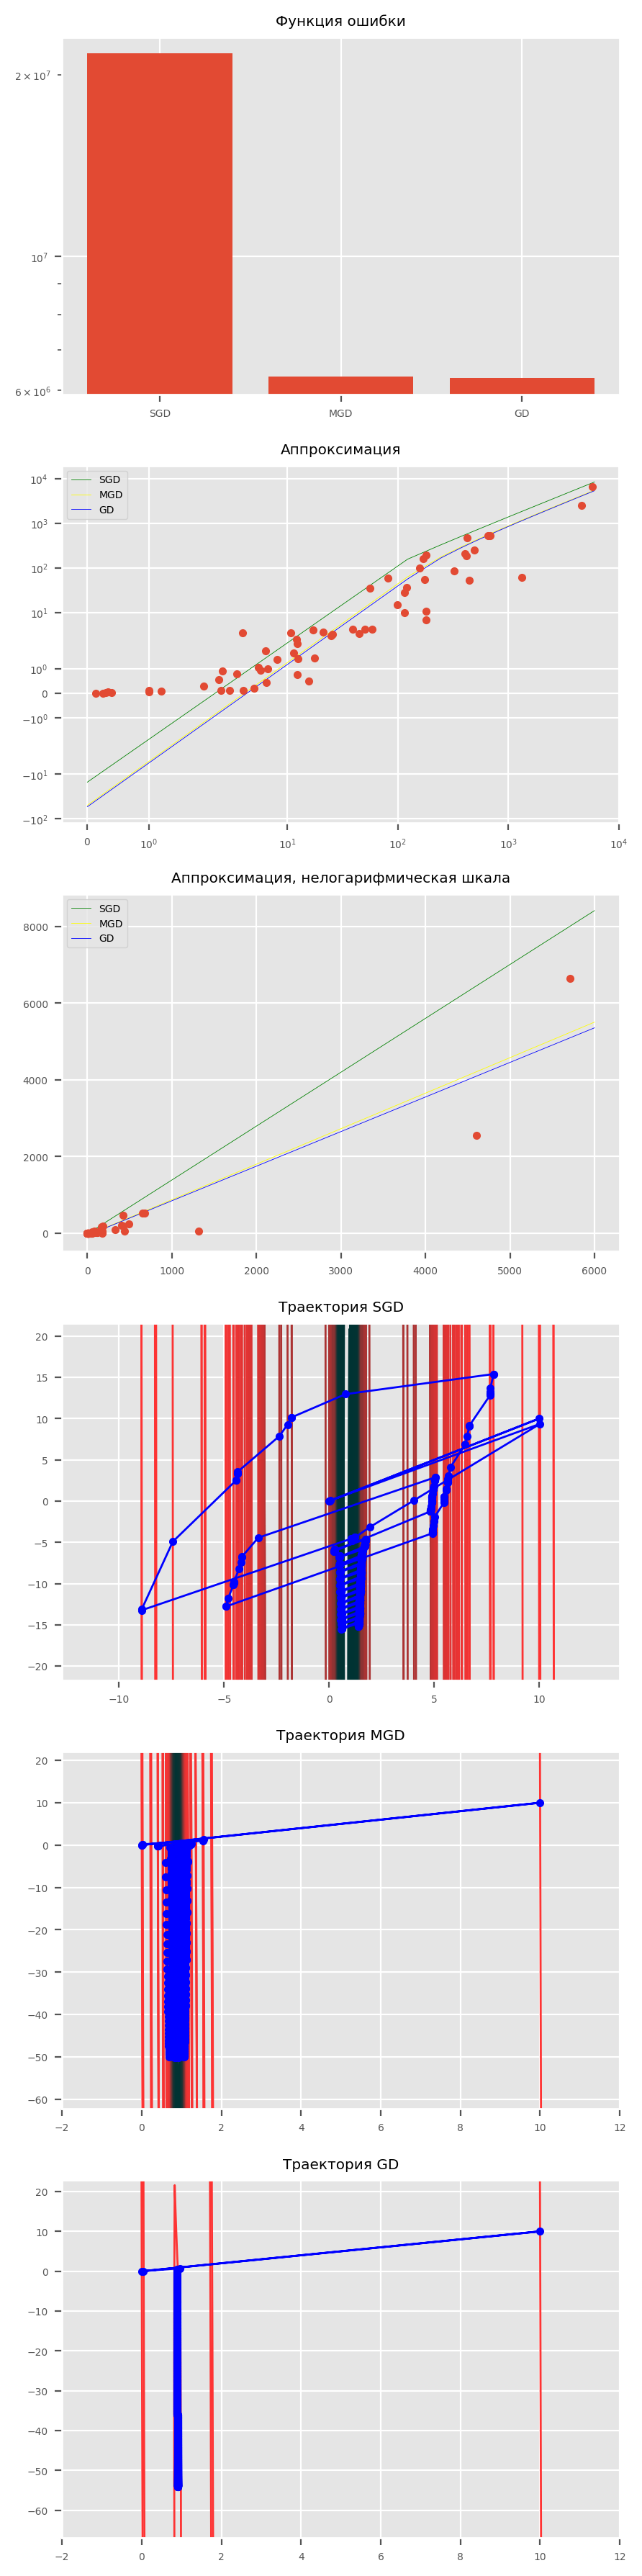

In [26]:
try:
    brains_and_weight_solve(mover=[AdaGradMover(),AdaGradMover(),AdaGradMover()], lr=10.0)
except FileNotFoundError:
    print("upload x01.txt and try again")

# lr=0.72 -> gd_error = 6348958
# lr=0.80 -> gd_error = 6342321
# lr=1.00 -> gd_error = 6329729
# lr=3.00 -> gd_error = 6307704
# lr=10.0 -> gd_error = 6307484

### 4) RMSProp
Проблема метода Adagrad в том, что сумма квадратов накапливается неограниченно, что в какой-то момент может привести в слишком медленным обновлениям параметра и параличу алгоритма. Для исправления этого недостатка были разработаны методы RMSProp и Adadelta.

Модифицируем идею Adagrad: вместо полной суммы обновлений, будем использовать усреднённый по истории квадрат градиента.

In [27]:
class RMSPropMover:
    EPS = 1e-8

    def __call__(self, x, lr, grad, **kwargs):
        gr = np.array(grad(*x))
        self.G = self.G * self.gamma + (1 - self.gamma) * (gr ** 2)
        adjusted_grad = gr / (EPS + np.sqrt(self.G))
        return x - lr * adjusted_grad, lr

    def __init__(self, gamma):
        self.x0 = 0
        self.G = 0
        self.gamma = gamma

Лучшие результаты и соответствующие им параметры:

* sgd: 6458826.512826407, gamma=0.9, lr=0.2111111111111111
* mgd: 6322219.670828425, gamma=0.9, lr=0.12222222222222223
* gd: 6451978.338640353, gama=0.9, lr=0.1

In [28]:
def rms_prop_find_best():
    gammas = np.linspace(0.8, 0.9, 10)
    lrs = np.linspace(0.1, 0.3, 10)
    min_sgd = [90000000, 0, 0]
    min_mgd = [90000000, 0, 0]
    min_gd = [90000000, 0, 0]

    for i in range(0, len(gammas)):
        for j in range(0, len(lrs)):
            sgd, mgd, gd = brains_and_weight_solve(mover=RMSPropMover(gammas[i]), lr=lrs[j], show=False)
            if sgd < min_sgd[0]:
                min_sgd = [sgd, gammas[i], lrs[j]]
            if mgd < min_mgd[0]:
                min_mgd = [mgd, gammas[i], lrs[j]]
            if gd < min_gd[0]:
                min_gd = [gd, gammas[i], lrs[j]]

    print(min_sgd, min_mgd, min_gd)

# опять же, лучше не запускать, считает долго
# rms_prop_find_best()

Значения функции ошибки:
[6449363.206993489, 6474558.441243491, 6927133.330900359]
Результаты методов:
[array([ 0.89096707, -2.38449489]), array([  0.95871603, -51.59188916]), array([  1.00810824, -55.56711831])]
Количество итераций:
[1001, 1001, 1001]
Точек всего: 62
Точек взято в minibatch: 20


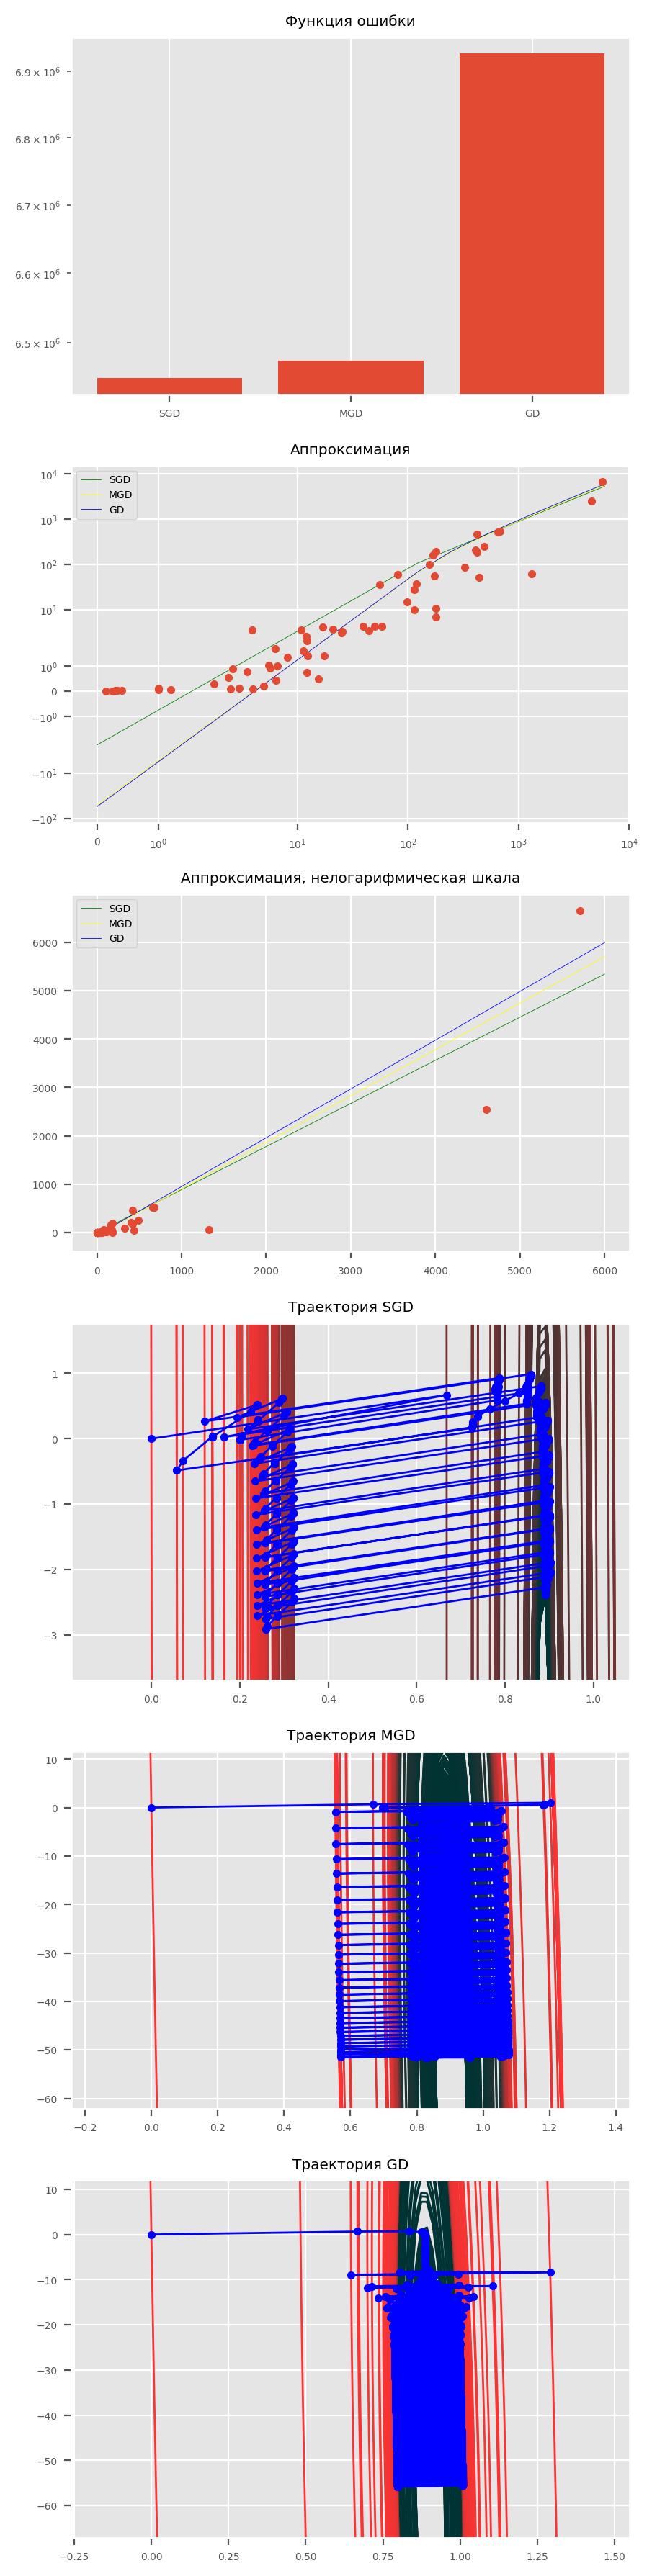

[6449363.206993489, 6474558.441243491, 6927133.330900359]

In [29]:
brains_and_weight_solve([RMSPropMover(0.9), RMSPropMover(0.9), RMSPropMover(0.9)], 0.21111, show=True)

### 5) Adam
Объединяет в себе основные идеи Momentum и Adagrad.

In [30]:
class AdamMover:
    EPS = 1e-8
    m_prev = 0
    v_prev = 0
    b = 0

    def __init__(self, b1, b2):
        self.b1 = b1
        self.b2 = b2

    def __call__(self, x, lr, grad, **kwargs):
        gr = np.array(grad(*x))
        m_new = self.b1 * self.m_prev + (1 - self.b1) * gr
        self.m_prev = m_new

        v_new = self.b2 * self.v_prev + (1 - self.b2) * np.power(gr, 2)
        self.v_prev = v_new

        t = kwargs.get("epoch")
        m = m_new / (1 - np.power(self.b1, t))
        v = v_new / (1 - np.power(self.b2, t))

        return x - lr * m / (np.sqrt(v) + self.EPS), lr

Лучшие результаты и соответствующие им параметры:
* 6447716.671743877, 0.98, 0.9400000000000001, 0.14
* 6315607.447484383, 0.98, 0.9, 0.18
* 6307484.405253196, 0.96, 0.96, 0.26

In [31]:
def adam_find_best():
    betas = np.linspace(0.9, 1.0, 6)
    lrs = np.linspace(0.1, 0.3, 6)
    min_sgd = [90000000, 0, 0, 0]
    min_mgd = [90000000, 0, 0, 0]
    min_gd = [90000000, 0, 0, 0]

    for i in range(0, len(betas)):
        for k in range(0, len(betas)):
            for j in range(0, len(lrs)):
                sgd, mgd, gd = brains_and_weight_solve(mover=AdamMover(betas[i], betas[k]), lr=lrs[j], show=False)
                if sgd < min_sgd[0]:
                    min_sgd = [sgd, betas[i], betas[k], lrs[j]]
                if mgd < min_mgd[0]:
                    min_mgd = [mgd, betas[i], betas[k], lrs[j]]
                if gd < min_gd[0]:
                    min_gd = [gd, betas[i], betas[k], lrs[j]]

    print(min_sgd, min_mgd, min_gd)

# adam_find_best()

Значения функции ошибки:
[6389627.744660295, 6284125.062504439, 6283529.168193453]
Результаты методов:
[array([  0.90087149, -14.30929226]), array([  0.90404245, -52.61568389]), array([  0.90017356, -55.96325771])]
Количество итераций:
[1001, 1001, 1001]
Точек всего: 62
Точек взято в minibatch: 20


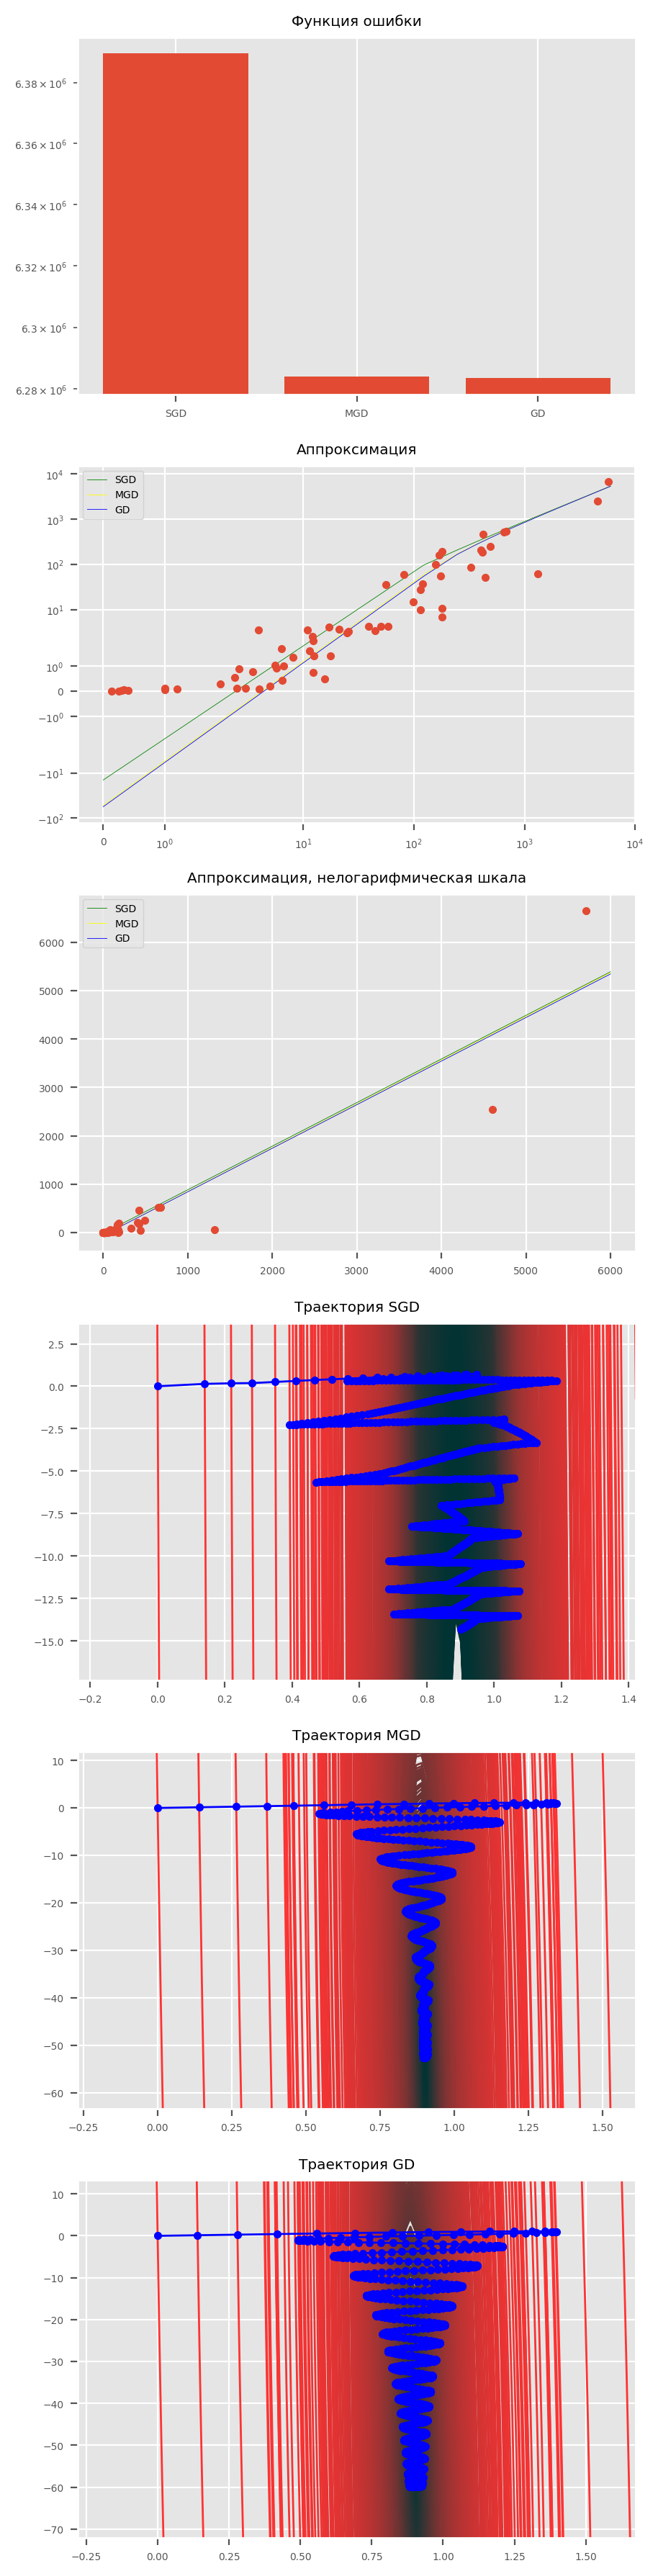

In [32]:
try:
    brains_and_weight_solve(mover=[AdamMover(0.98, 0.94),AdamMover(0.98, 0.94),AdamMover(0.98, 0.94)], lr=0.14, show=True)
except FileNotFoundError:
    print("upload x01.txt and try again")

### Сравнение результатов работы разных алгоритмов.
SGD создавался с целью экономии ресурсов во время вычислений функций на больших датасетах.
Можем видеть, что благодаря модификациям SGD показывает результат не хуже GD, при этом сохраняя свои преимущества.

exp_gd 6441473.585152911
momentum 6463505.038769288
nesterov 6463355.4636754505
adagrad 6463468.037531917
rmsprop 6449363.206993489
adam 6389627.744660295


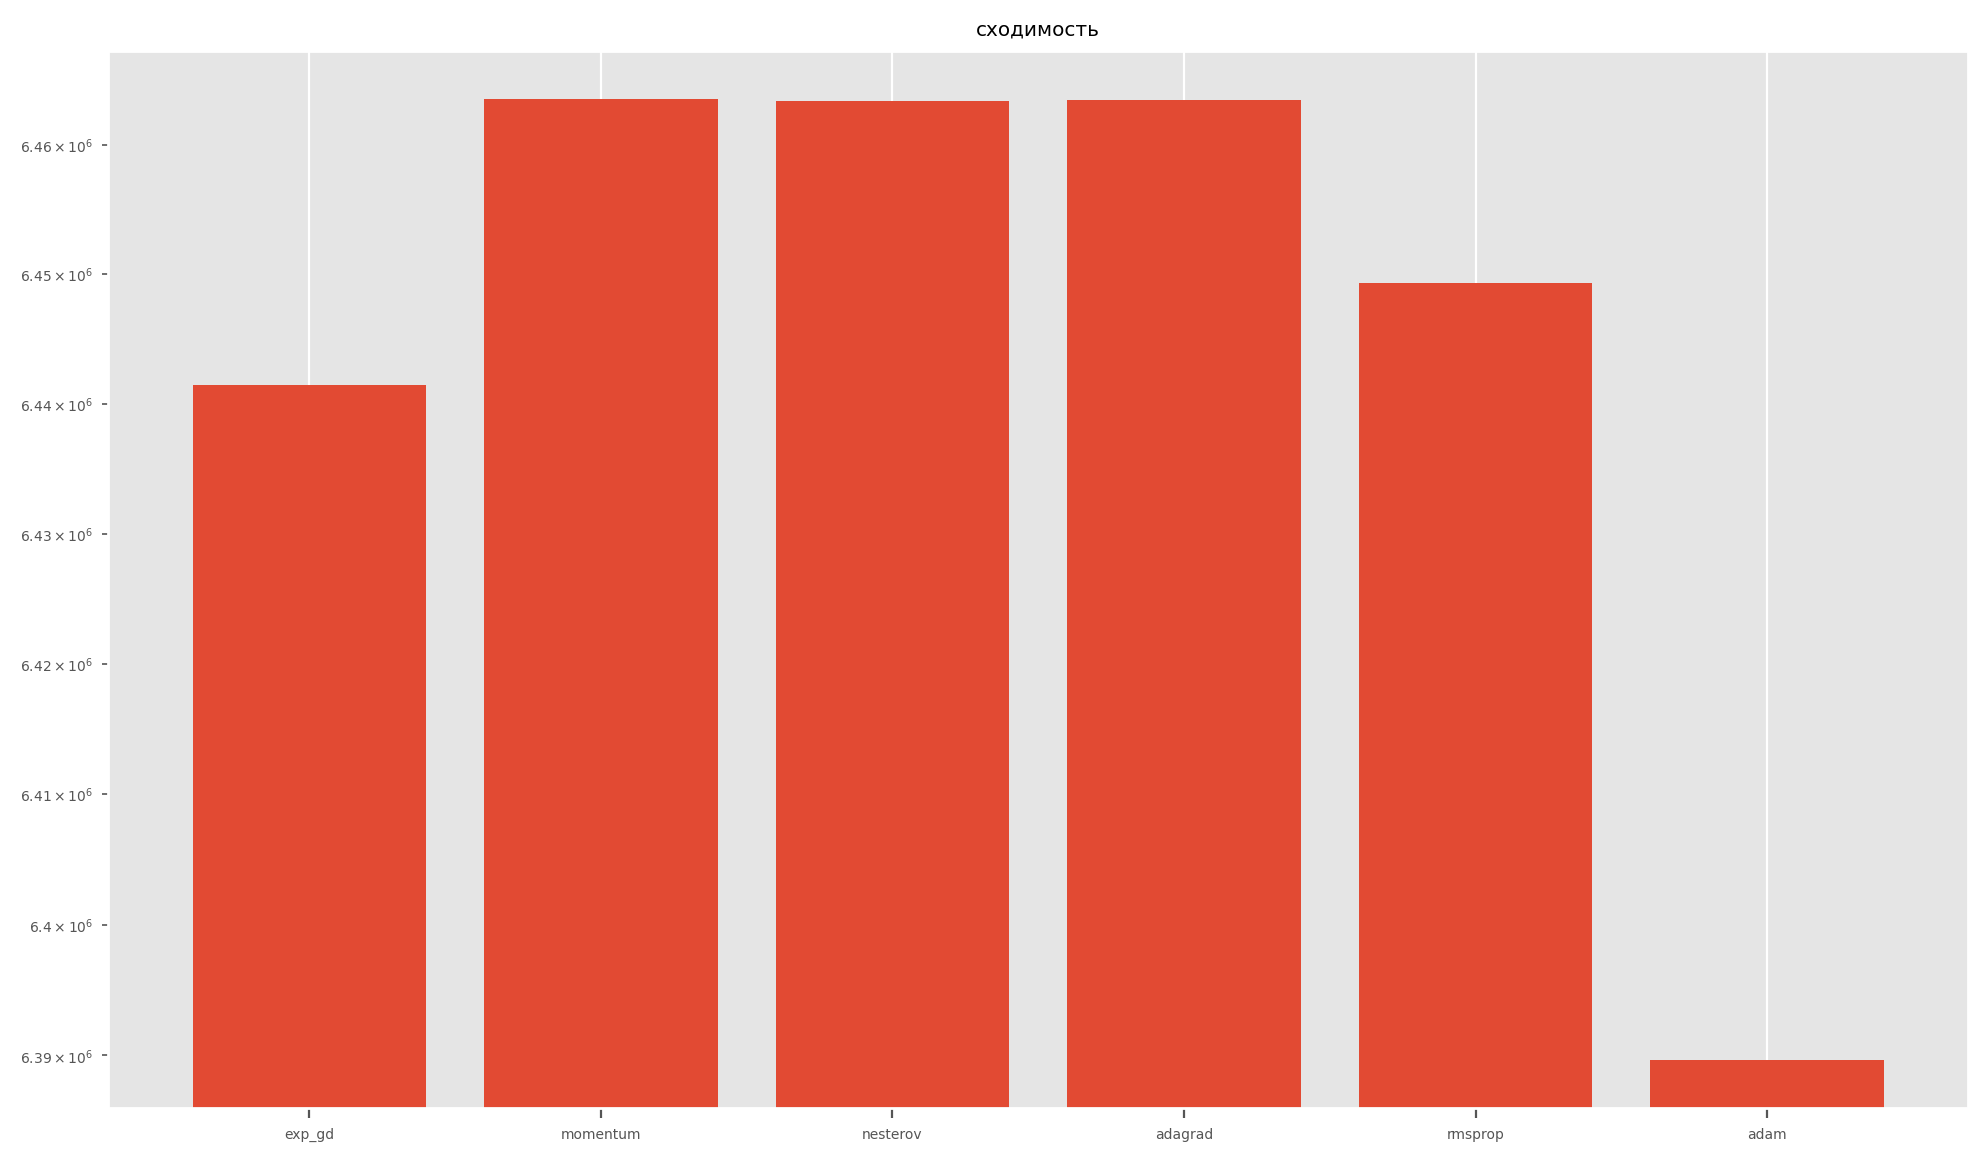

In [33]:
def convergence_comparison():
    # Exponential mover (GD)
    exp_gd = brains_and_weight_solve(show=False)[2]
    print("exp_gd", exp_gd)

    # Momentum mover
    momentum = brains_and_weight_solve(MomentumMover(0.6), lr=0.000000002, show=False)[
        0]  # наверное можно чуток лучше
    print("momentum", momentum)

    # Nesterov
    nesterov = brains_and_weight_solve(NesterovMover(0.9), 0.0000000002, show=False)[0]  # не уверен, что можно лучше
    print("nesterov", nesterov)

    # Adagrad
    adagrad = brains_and_weight_solve(AdaGradMover(), lr=0.16, show=False)[0]  # оптимальнее некуда
    print("adagrad", adagrad)

    # RMSProp
    rmsprop = brains_and_weight_solve(RMSPropMover(0.9), 0.21111, show=False)[0]  # вроде дальше некуда
    print("rmsprop", rmsprop)

    # Adam
    adam = brains_and_weight_solve(AdamMover(0.98, 0.9400000000000001), lr=0.14, show=False)[0]  # не а где, а адам
    print("adam", adam)

    _, ax = plt.subplots(figsize=(12, 7))
    labels = ("exp_gd", "momentum", "nesterov", "adagrad", "rmsprop", "adam")
    values = (exp_gd, momentum, nesterov, adagrad, rmsprop, adam)

    basic_bar_chart(ax, labels, values, title="сходимость", log=True) # можно и с log=True потом запустить
    plt.show()


try:
    convergence_comparison()
except FileNotFoundError:
    print("upload x01.txt and try again")

In [34]:
def adam_find_best2():
    betas = np.linspace(0.7, 1.0, 9)
    lrs = np.linspace(0.1, 0.9, 9)
    min_sgd = [90000000, 0, 0, 0]
    min_mgd = [90000000, 0, 0, 0]
    min_gd = [90000000, 0, 0, 0]

    for i in range(0, len(betas)):
        for k in range(0, len(betas)):
            for j in range(0, len(lrs)):
                sgd, mgd, gd = fish_solve(mover=AdamMover(betas[i], betas[k]), lr=lrs[j], show=False)
                if sgd < min_sgd[0]:
                    min_sgd = [sgd, betas[i], betas[k], lrs[j]]
                if mgd < min_mgd[0]:
                    min_mgd = [mgd, betas[i], betas[k], lrs[j]]
                if gd < min_gd[0]:
                    min_gd = [gd, betas[i], betas[k], lrs[j]]

    print(min_sgd, min_mgd, min_gd)

# adam_find_best2()

Бонус-решение задачи про рыб с помощью Adam

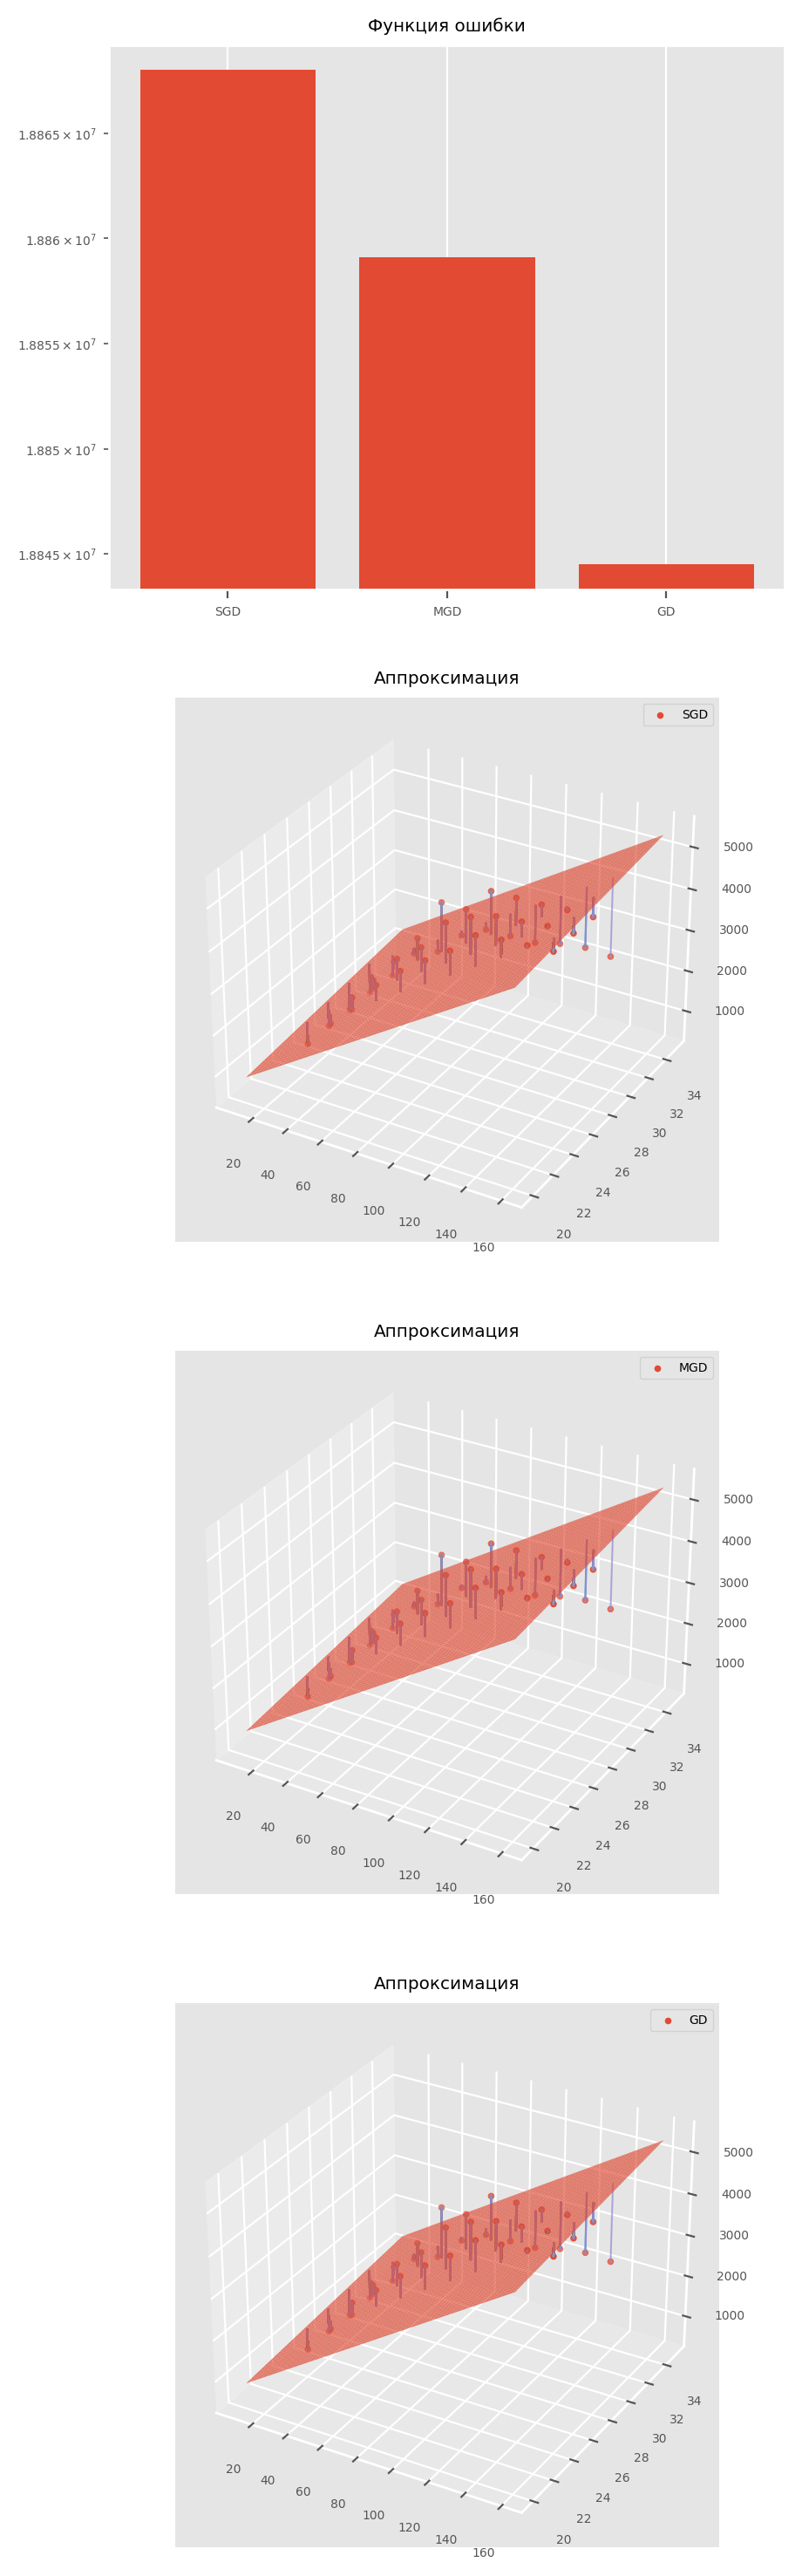

Значения функции ошибки:
[18868010.890754137, 18859098.840882584, 18844503.302610893]
Результаты методов:
[array([27.02161006, 29.20448455, 29.00888049]), array([27.32400066, 27.72333603, 28.7593004 ]), array([27.19602533, 27.90277468, 35.72014584])]
Количество итераций:
[501, 501, 501]
Точек всего: 44
Точек взято в minibatch: 11
Лучшее приближение:
длина рыбы в у.е. = 27.19602532586611 * возраст + 27.90277467709328 * температура воды + 35.72014583663434
without Adam: [23524697.89316215, 21814032.48727129, 18787364.305004258]


In [41]:
try:
    epoches_limiter = stop_cond=lambda prev_x, new_x, epoch: epoch > 500
    fish_solve(mover=[AdamMover(0.9625, 0.9625),AdamMover(0.9625, 0.9625),AdamMover(0.9625, 0.9625)], lr=0.1, stop_cond=epoches_limiter)
    print('without Adam:', fish_solve(show=False, stop_cond=epoches_limiter))
except FileNotFoundError:
    print("upload x06.txt and try again")

## Задание 4

Исследуйте сходимость алгоритмов. Сравните различные методы по скорости сходимости, надежности, требуемым машинным ресурсам (объему оперативной памяти, количеству арифметических операций, времени выполнения).

1. Сходимость мы уже показали: все модификации SGD по сходимости отличаются на небольшую константу. Лучшим среди модификаций оказался Adam.

2. Будем имитировать невозможность тщательного подбора learning rate. Самой надежной модификацией SGD является AdaGrad, поскольку даже при высоких значениях lr он показал хорошую сходимость ранее, а потом мы подтвердим это ниже. Следующими по этой характеристике будут методы, также учитывающие накопленную сумму, но умеющие ее забывать: это Adam и RMSProp. Все три метода накапливали сумму в векторе, то есть учитывали отдельно каждую координату. Последними по надежности будут методы, использующие предугадывание (шаг вперед) и инерцию - это момент Нестерова и метод Momentum.

3. Сравнение требуемого объема оперативной памяти: каждая из рассмотренных модификаций требовала хранение вектора нецелых чисел с размером, равным размерности задачи. Нецелые числа на наших машинах кодируются как тип double-precision из IEEE 754, то есть для хранения одного числа требуется 64 бита. Ровно так работает AdaGrad. Модификации SGD, такие как Momentum, Nesterov и RMSProp хранят также дополнительный double - коэффициент, который они используют для пересчета нового положения икс. Замыкающим станет Adam, который требует O(2*k) нецелых чисел в оперативной памяти, где k - размерность задачи.

4. Количество арифметических операций сильно варьируется: Momentum < Nesterov* (он вызывает градиент дважды - непонятно как оценивать) < AdaGrad < RMSProp < Adam

5. Время выполнения обратно пропорционально скорости сходимости и прямо пропорционально размеру датасета и сложности алгоритма (см. раздел 3).

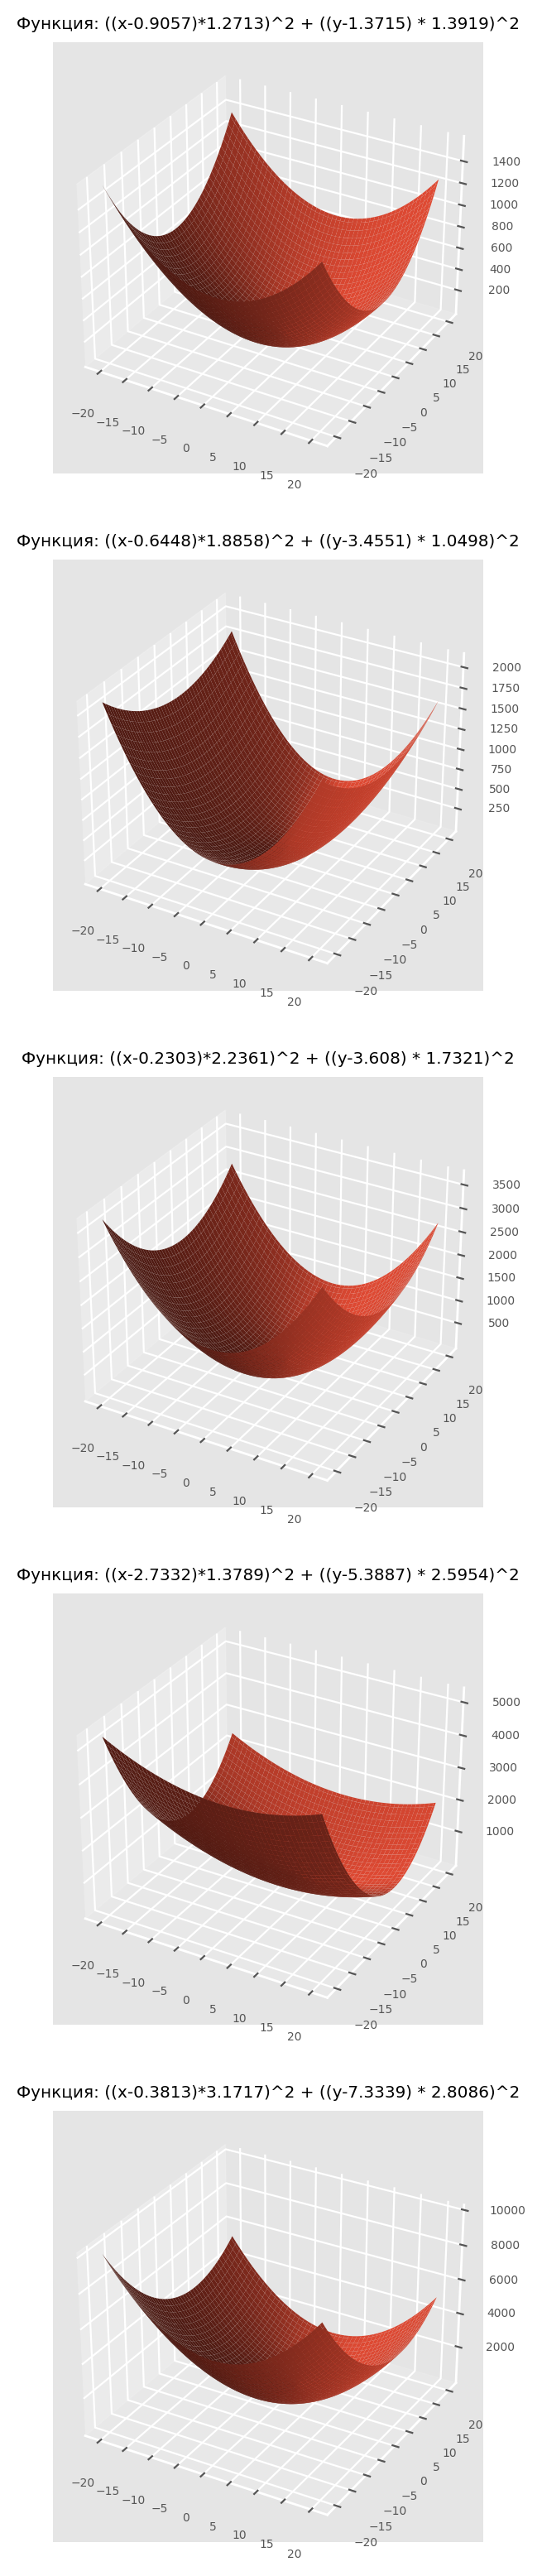

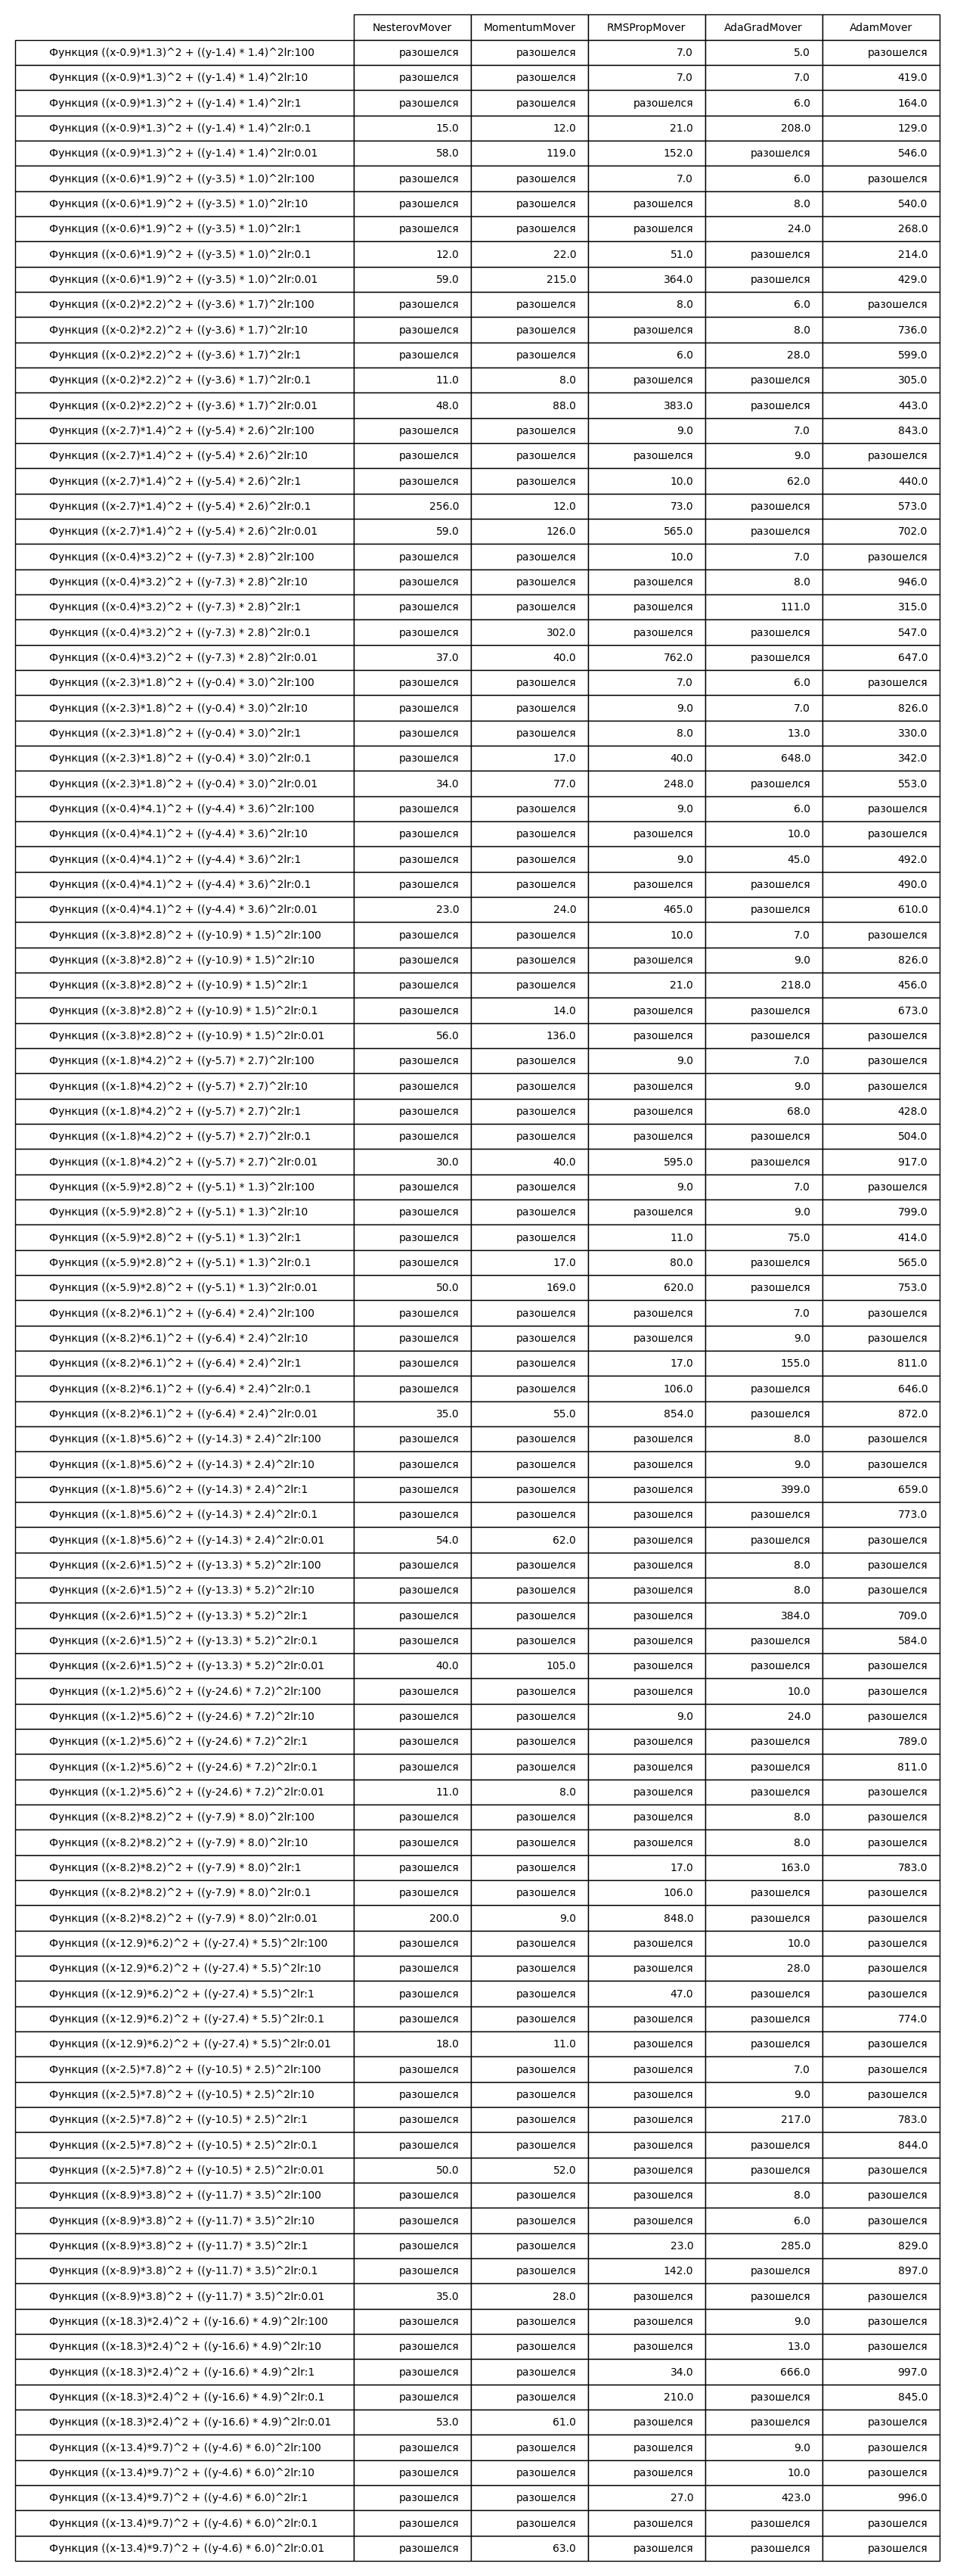

In [50]:
def test_movers(test_count=20):
    def parametized_parabola(x_root, y_root, x_mul, y_mul):
        return lambda x, y: ((x - x_root) * x_mul)**2 + ((y - y_root) * y_mul)**2
    
    def random_parabola(i):
        roots =(np.random.rand() * i, np.random.rand() * 2 * i)
        muls = (1 + np.random.rand() * (i * 0.5), 1 +  np.random.rand() * i/2)
        return (parametized_parabola(*roots, *muls), roots, muls)
    #gen functions
    funcs=[random_parabola(i+1) for i in range(test_count)]
    
    def str_parabola(par, short= False):
        r_s = lambda v: str(round(v, 1 if short else 4))
        return "((x-" + r_s(par[1][0]) + ")*"+ r_s(par[2][0]) + ")^2 + "+ "((y-"+  r_s(par[1][1])+ ") * "+ r_s(par[2][1])+")^2"
        
    # print_parabola(funcs[0])
    fig = plt.figure(figsize=(5, 20))
    axes = [fig.add_subplot(5, 1, i + 1, projection='3d') for i in range(5)]
    for i in range(len(axes)):
        draw_3d(funcs[i][0], axes[i], title="Функция: " + str_parabola(funcs[i]))
        
    global_lrs = [100, 10, 1, 0.1, 0.01]
    
    def get_movers():
        return[NesterovMover(0.9),
        MomentumMover(0.006),
        RMSPropMover(0.85),
        AdaGradMover(), 
        AdamMover(0.98, 0.9400000000000001)]
    
    mover_names= ["NesterovMover","MomentumMover","RMSPropMover","AdaGradMover", "AdamMover"]
    
    def basic_desired_cond_factory(func, desired=0, eps=1e-3):
        return lambda new_x, prev_x, **kwargs: abs(func(*new_x) - desired) < eps
    
    def get_statictics(func, mover, lr):
        u_g = universal_grad_2D(func)
        pts = grad_descent(u_g, mover, np.array([0, 0]), lr, basic_desired_cond_factory(func))
        result = func(*pts[-1])
        cnt = pts.size / 2
        if (cnt == 1001):
            return "разошелся"
        return cnt
    
    def test(func, lr):
        movers = get_movers()
        return [get_statictics(func, movers[i], lr) for i in range(len(movers))]
    
    
    res = []
    for i in range(len(funcs)):
        for j in range(len(global_lrs)):
            res.append(test(funcs[i][0], global_lrs[j]))
    
    fig, (ax) = plt.subplots()

    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    
    row_names = []
    for i in range(test_count):
        for lr in global_lrs:
            row_names.append("Функция " + str_parabola(funcs[i], True) + "lr:" + str(lr))

    #create table
    table = ax.table(cellText=res, colLabels=mover_names, rowLabels=row_names, loc='center')
    for cell in table.get_children():
            cell.get_text().set_color('black')
    row_names = ["Успешных запусков", "Итераций в среднем"]
    success=[0,0,0,0,0]
    total_iter = [0,0,0,0,0]
    for i in range(5):
        for f in range(test_count * len(global_lrs)):
            if res[f][i] != "разошелся":
                success[i] = success[i] + 1
                total_iter[i] = int(res[f][i]) + total_iter[i]
                
    avg_iter = [total_iter[i] / success[i] if success[i] != 0 else "-" for i in range(5)]
    data = [success, avg_iter]

    # ax1.table(cellText=data, colLabels=mover_names, rowLabels=row_names, loc='center')

   
    plt.show()
    return (data, mover_names, row_names)
    
test_data = test_movers()

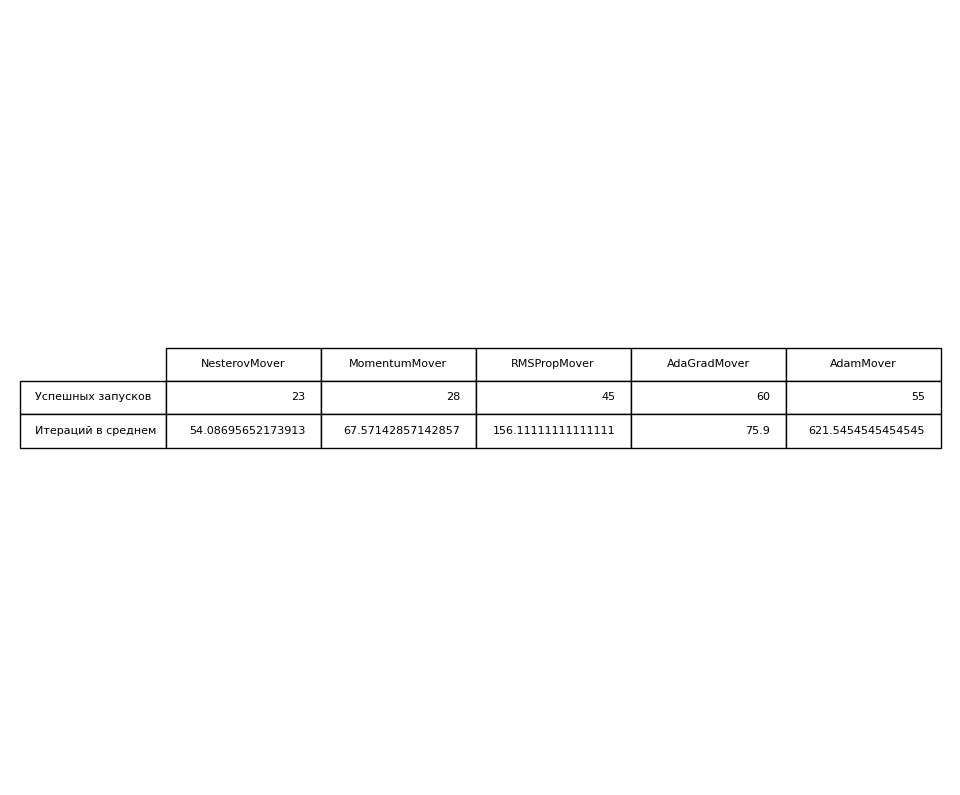

In [51]:
def gg() :
  fig, (ax) = plt.subplots()
  fig.patch.set_visible(False)
  ax.axis('off')
  ax.axis('tight')
  table = ax.table(cellText=test_data[0], colLabels=test_data[1], rowLabels=test_data[2], loc='center')
  for cell in table.get_children():
    cell.get_text().set_color('black')
  plt.show()
  
gg()